In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import warnings

In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [4]:
import matplotlib

In [5]:
import hdbscan
import pyarrow.dataset as ds

In [6]:
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.visible'] = 'True'
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.visible'] = 'True'
plt.rcParams['axes.linewidth'] = 1.2

In [7]:
plt.rcParams['figure.figsize'] = [10,8]
font = {'size'   : 20}
plt.rc('font', **font)

In [8]:
df=pd.read_csv('WAVES_cluster_label.csv').set_index('uberID')

In [9]:
df['mag_u_tot']=8.9-2.5*np.log10(df['flux_ut'])
df['mag_g_tot']=8.9-2.5*np.log10(df['flux_gt'])
df['mag_r_tot']=8.9-2.5*np.log10(df['flux_rt'])
df['mag_i_tot']=8.9-2.5*np.log10(df['flux_it'])
df['mag_z_tot']=df['mag_Zt']
df['mag_y_tot']=8.9-2.5*np.log10(df['flux_Yt'])
df['mag_j_tot']=8.9-2.5*np.log10(df['flux_Jt'])
df['mag_h_tot']=8.9-2.5*np.log10(df['flux_Ht'])
df['mag_k_tot']=8.9-2.5*np.log10(df['flux_Kt'])

/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/its/home/tc339/.conda/envs/en

In [10]:
df_nan=df
del df

In [11]:
df_nan.columns

Index(['FrameID', 'segID', 'xmax', 'ymax', 'censep', 'RAcen', 'Deccen',
       'RAmax', 'Decmax', 'RAGAIA', 'DecGAIA', 'sky_mean', 'skyRMS_mean',
       'log10seeing', 'mag', 'R50', 'R90', 'R100', 'N100', 'axrat', 'ang',
       'groupID', 'Ngroup', 'mag_app_ut', 'mag_app_gt', 'mag_app_rt',
       'mag_app_it', 'mag_app_Zt', 'mag_app_Yt', 'mag_app_Jt', 'mag_app_Ht',
       'mag_app_Kt', 'mag_Zt', 'flux_ut', 'flux_err_ut', 'flux_gt',
       'flux_err_gt', 'flux_rt', 'flux_err_rt', 'flux_it', 'flux_err_it',
       'flux_Zt', 'flux_err_Zt', 'flux_Yt', 'flux_err_Yt', 'flux_Jt',
       'flux_err_Jt', 'flux_Ht', 'flux_err_Ht', 'flux_Kt', 'flux_err_Kt',
       'flux_uc', 'flux_err_uc', 'flux_gc', 'flux_err_gc', 'flux_rc',
       'flux_err_rc', 'flux_ic', 'flux_err_ic', 'flux_Zc', 'flux_err_Zc',
       'flux_Yc', 'flux_err_Yc', 'flux_Jc', 'flux_err_Jc', 'flux_Hc',
       'flux_err_Hc', 'flux_Kc', 'flux_err_Kc', 'mask', 'starscol',
       'starssize', 'class', 'noOPT_r', 'noOPT_i', 'noIR_Z', 'no

In [12]:
df_nan=df_nan[['RAmax', 'Decmax', 'R50', 'R90', 'R100', 'axrat', 'class', 
       'cluster_label', 'missing_bands', 'mag_u_tot', 'mag_g_tot', 'mag_r_tot',
       'mag_i_tot', 'mag_z_tot', 'mag_y_tot', 'mag_j_tot', 'mag_h_tot',
       'mag_k_tot','flux_Zt','log10seeing']]

(array([10008317.,        0.,        0.,        0.,        0.,  3309030.,
               0.,        0.,        0.,  1644348.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

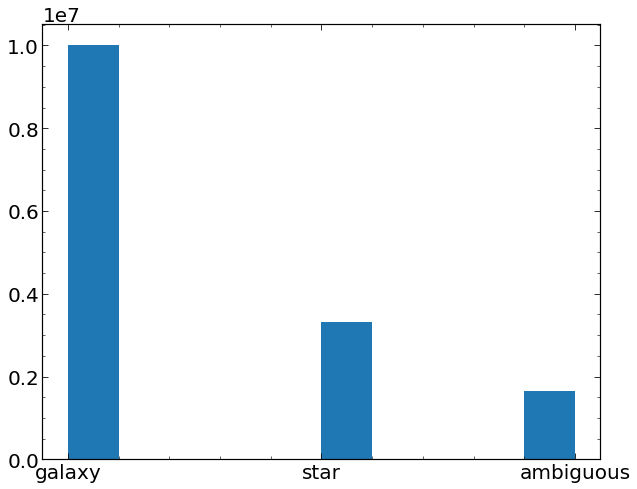

In [13]:
plt.hist(df_nan['class'])

In [14]:
df_smol=df_nan

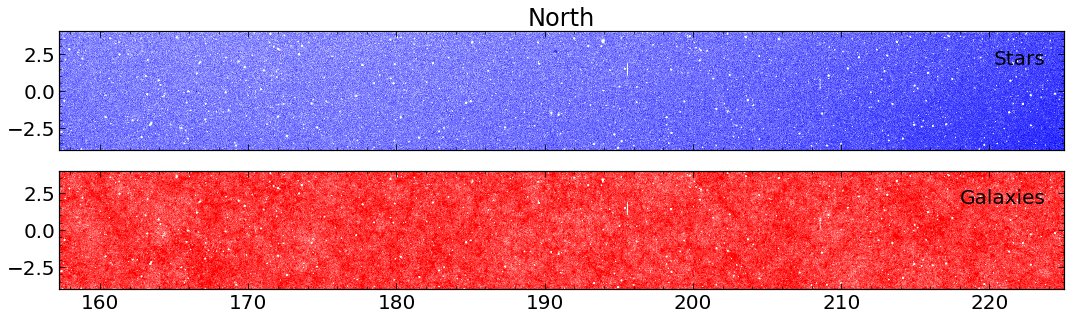

In [15]:
fig, axs = plt.subplots(2, 1, sharex=True,figsize=(18,5))
fig.subplots_adjust(hspace=0.05)

axs[0].scatter(df_smol[((df_smol['cluster_label']=='star')|(df_smol['cluster_label']=='ambiguous')) & (df_smol['Decmax']>-20)]['RAmax'],
            df_smol[((df_smol['cluster_label']=='star')|(df_smol['cluster_label']=='ambiguous')) & (df_smol['Decmax']>-20)]['Decmax'],
                   linewidth=0,s=0.02,c='blue',label='Stars')
axs[0].set_xlim(157.25,225)
axs[0].set_ylim(-4,4)
axs[0].set_aspect('equal', adjustable='box')
axs[0].legend(loc='upper right',frameon=False,labelcolor='k')
axs[0].set_title('North')


axs[1].scatter(df_smol[(df_smol['cluster_label']=='galaxy') & (df_smol['Decmax']>-20)]['RAmax'],
            df_smol[(df_smol['cluster_label']=='galaxy') & (df_smol['Decmax']>-20)]['Decmax'],
                   linewidth=0,s=0.02,c='red',label='Galaxies')
axs[1].set_xlim(157.25,225)
axs[1].set_ylim(-4,4)
axs[1].set_aspect('equal', adjustable='box')
axs[1].legend(loc='upper right',frameon=False,labelcolor='k')

#plt.savefig('ra_dec_north.jpg',bbox_inches='tight',dpi=500)

plt.show()

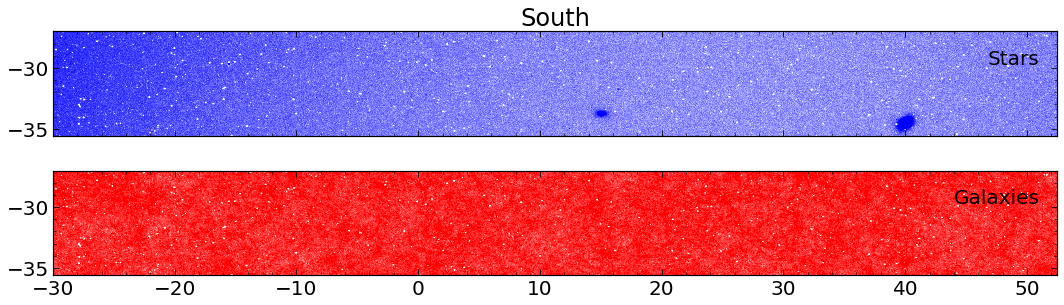

In [16]:
fig, axs = plt.subplots(2, 1, sharex=True,figsize=(18,5))
fig.subplots_adjust(hspace=0.05)

axs[0].scatter(df_smol[((df_smol['cluster_label']=='star')|(df_smol['cluster_label']=='ambiguous')) & (df_smol['Decmax']<-20)]['RAmax'],
            df_smol[((df_smol['cluster_label']=='star')|(df_smol['cluster_label']=='ambiguous')) & (df_smol['Decmax']<-20)]['Decmax'],
                   linewidth=0,s=0.02,c='blue',label='Stars')
axs[0].set_xlim(-30,52.5)
axs[0].set_ylim(-35.6,-27)
axs[0].set_aspect('equal', adjustable='box')
axs[0].legend(loc='upper right',frameon=False,labelcolor='k')
axs[0].set_title('South')


axs[1].scatter(df_smol[(df_smol['cluster_label']=='galaxy') & (df_smol['Decmax']<-20)]['RAmax'],
            df_smol[(df_smol['cluster_label']=='galaxy') & (df_smol['Decmax']<-20)]['Decmax'],
                   linewidth=0,s=0.02,c='red',label='Galaxies')
axs[1].set_xlim(-30,52.5)
axs[1].set_ylim(-35.6,-27)
axs[1].set_aspect('equal', adjustable='box')
axs[1].legend(loc='upper right',frameon=False,labelcolor='k')

#plt.savefig('ra_dec_south.jpg',bbox_inches='tight',dpi=500)

plt.show()

In [17]:
del df_smol

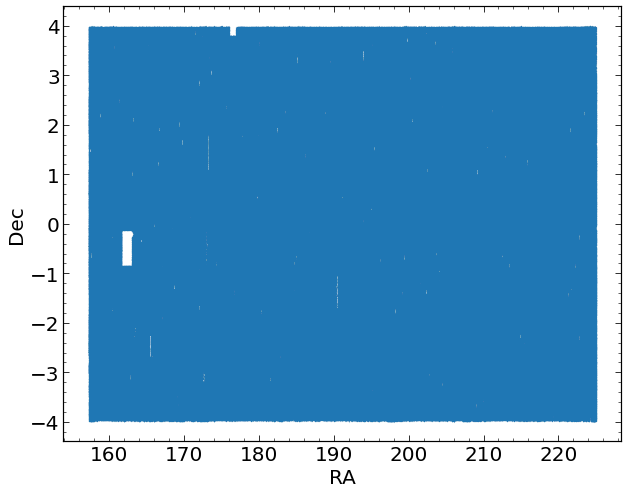

In [18]:
plt.scatter(df_nan[(df_nan['missing_bands']==False) & (df_nan['Decmax']>-20)]['RAmax'],
            df_nan[(df_nan['missing_bands']==False) & (df_nan['Decmax']>-20)]['Decmax'],
            s=0.01)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

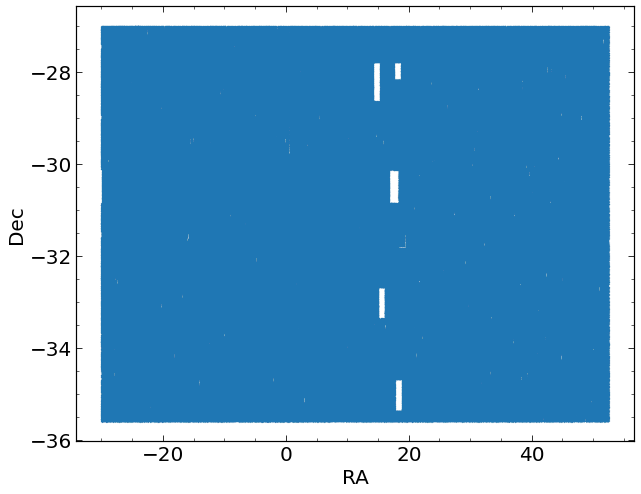

In [19]:
plt.scatter(df_nan[(df_nan['missing_bands']==False) & (df_nan['Decmax']<-20)]['RAmax'],
            df_nan[(df_nan['missing_bands']==False) & (df_nan['Decmax']<-20)]['Decmax'],
            s=0.01)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

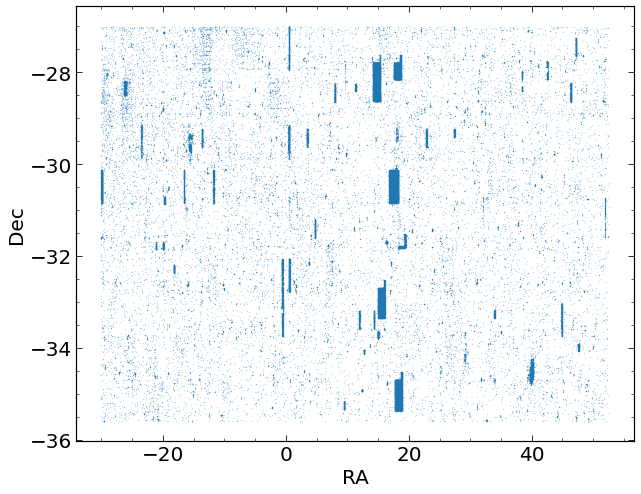

In [20]:
plt.scatter(df_nan[(df_nan['missing_bands']==True) & (df_nan['Decmax']<-20)]['RAmax'],
            df_nan[(df_nan['missing_bands']==True) & (df_nan['Decmax']<-20)]['Decmax'],
            s=0.01)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [21]:
(len(df_nan[df_nan['missing_bands']==True])/len(df_nan))*100

1.0671451329545216

In [22]:
features=['flux_ut','flux_gt','flux_rt','flux_it','flux_Zt',
          'flux_Yt','flux_Jt','flux_Ht','flux_Kt','RAmax','Decmax']

In [23]:
df_lim=df_nan[features]

KeyError: "['flux_ut', 'flux_gt', 'flux_rt', 'flux_it', 'flux_Zt', 'flux_Yt', 'flux_Jt', 'flux_Ht', 'flux_Kt'] not in index"

In [ ]:
for feature in tqdm(features):
    print(feature,len(df_nan[df_nan[feature].isna()]),
          round(100*len(df_nan[df_nan[feature].isna()])/len(df_nan),3))

In [ ]:
features=['mag_u_tot','mag_g_tot','mag_r_tot','mag_i_tot','mag_z_tot','mag_y_tot','mag_j_tot','mag_h_tot','mag_k_tot']
df_lim=df_nan[features]
for feature in tqdm(features):
    print(feature,len(df_nan[df_nan[feature].isna()]),
          round(100*len(df_nan[df_nan[feature].isna()])/len(df_nan),3))

In [ ]:
df_lim=df_lim[df_lim.isnull().any(axis=1)]

In [ ]:
(len(df_lim)/len(df_nan))*100 - 1.0671451329545216

In [ ]:
df_lim=df_nan[df_nan['cluster_label']=='star'][::10]

In [ ]:
plt.scatter(df_lim['mag_z_tot'][::10],
            np.log10(df_lim['R50'][::10]),
            c=df_lim['log10seeing'][::10],
            s=1)
plt.ylim(-0.5,0)
plt.xlim(15,21.2)
plt.colorbar()
plt.show()

In [ ]:
plt.scatter(df_lim['mag_z_tot'],
            np.log10(df_lim['R50'])-df_lim['log10seeing'],
            c=df_lim['log10seeing'],
            s=1)
plt.ylim(-0.2,0.2)
plt.xlim(15,21.2)
plt.colorbar()
plt.show()

In [ ]:
df_test=df_nan[(df_nan['Decmax']<-20) & (df_nan['R50']>0)]

In [ ]:
percentile

In [ ]:
percentile=np.percentile(np.log10(df_test['R50'])-df_test['log10seeing'],99)
df_lim=df_test[(np.log10(df_test['R50'])-df_test['log10seeing'])>percentile]

In [ ]:
plt.scatter(df_lim['RAmax'],df_lim['Decmax'],s=0.1)
plt.show()

In [ ]:
plt.hist(df_lim['Decmax'],bins=100)
plt.show()

In [ ]:
plt.hist(df_nan['log10seeing'],bins=100)
plt.show()

In [ ]:
plt.hist(np.log10(df_nan['R50']),bins=np.linspace(-0.5,-0.2,100))
plt.yscale('log')
plt.show()

In [ ]:
plt.scatter(df_nan['log10seeing'],np.log10(df_nan['R50']),s=0.01)
plt.ylim(-0.45,0)
plt.show()

In [ ]:
df_lim=df_nan[(df_nan['Decmax']<-20)][::1]

In [ ]:
#plt.figure(figsize=(20,20))
#for frame in tqdm(np.unique(df_lim['FrameID'])):
#    plt.scatter(df_lim[df_lim['FrameID']==frame]['RAmax'],
#               df_lim[df_lim['FrameID']==frame]['Decmax'],s=1)
#plt.xlim(-18,-11)
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')    
#plt.show()

In [ ]:
#plt.figure(figsize=(20,20))
#plt.scatter(df_lim['RAmax'],df_lim['Decmax'],c=df_lim['log10seeing'],s=1)
#plt.xlim(-18,-11)
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')    
#plt.show()

In [ ]:
df_lim=df_nan[df_nan['missing_bands']==False]

In [ ]:
print(len(df_lim[df_lim['class']=='galaxy']))
print(len(df_lim[df_lim['class']=='galaxy'])/len(df_lim))
print(len(df_lim[df_lim['class']=='star']))
print(len(df_lim[df_lim['class']=='star'])/len(df_lim))
print(len(df_lim[df_lim['class']=='ambiguous']))
print(len(df_lim[df_lim['class']=='ambiguous'])/len(df_lim))

In [ ]:
print(len(df_lim[df_lim['cluster_label']=='galaxy']))
print(len(df_lim[df_lim['cluster_label']=='galaxy'])/len(df_lim))
print(len(df_lim[df_lim['cluster_label']=='star']))
print(len(df_lim[df_lim['cluster_label']=='star'])/len(df_lim))

In [ ]:
(9890177+1623377) - 9840796

In [ ]:
1672758/len(df_lim)

In [ ]:
del df_lim

In [ ]:
df_lim=df_nan[df_nan['FrameID']==34170]

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
axes[0].scatter(df_lim[df_lim['class']=='star']['RAmax'],df_lim[df_lim['class']=='star']['Decmax'],s=1)
axes[0].set_xlim(-20,-18.9)
axes[0].set_ylim(-30.8,-29.6)
axes[0].axhline(-30.1)
axes[0].set_title('Baseline stars',fontsize=15)
axes[0].set_aspect('equal', adjustable='box') 
axes[1].scatter(df_lim[df_lim['cluster_label']=='star']['RAmax'],df_lim[df_lim['cluster_label']=='star']['Decmax'],s=1)
axes[1].set_xlim(-20,-18.9)
axes[1].set_ylim(-30.8,-29.6)
axes[1].axhline(-30.1)
axes[1].set_aspect('equal', adjustable='box') 
axes[1].set_yticklabels([])
axes[1].set_title('Cluster label stars',fontsize=15)

axes[2].scatter(df_lim[(df_lim['cluster_label']=='star') & (df_lim['class']=='galaxy')]['RAmax'],
                df_lim[(df_lim['cluster_label']=='star') & (df_lim['class']=='galaxy')]['Decmax'],
                s=1)
axes[2].set_xlim(-20,-18.9)
axes[2].set_ylim(-30.8,-29.6)
axes[2].axhline(-30.1)
axes[2].set_aspect('equal', adjustable='box') 
axes[2].set_yticklabels([])
axes[2].set_title('Baseline Galaxy & Cluster label stars',fontsize=15)


plt.savefig('Frame31470.jpg',bbox_inches='tight',dpi=500)



plt.show()

NameError: name 'df_lim' is not defined

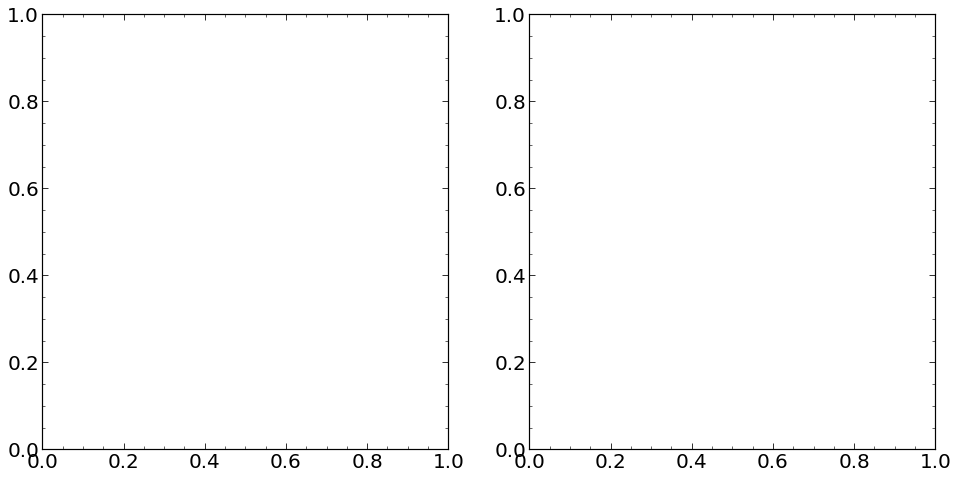

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].hist(df_lim[df_lim['class']=='galaxy']['Decmax'],bins=np.linspace(-30.8,-29.6,20),histtype='step')
axes[0].set_title('Baseline stars')
axes[0].set_xlabel('Dec')
axes[0].axvline(-30.1)


axes[1].hist(df_lim[df_lim['cluster_label']=='galaxy']['Decmax'],bins=np.linspace(-30.8,-29.6,20),histtype='step')
axes[1].set_title('Cluster label stars')
axes[1].set_xlabel('Dec')
axes[1].axvline(-30.1)



In [ ]:
plt.scatter(df_lim[(df_lim['cluster_label']=='star') & (df_lim['class']=='galaxy')]['RAmax'],
           df_lim[(df_lim['cluster_label']=='star') & (df_lim['class']=='galaxy')]['Decmax'],s=5)

In [ ]:
 plt.scatter(df_nan[(df_nan['cluster_label']=='star') & (df_nan['class']=='galaxy') & 
                 (df_nan['Decmax']<-20) & (df_nan['missing_bands']==False) ]['RAmax'],
            df_nan[(df_nan['cluster_label']=='star') & (df_nan['class']=='galaxy') & 
                 (df_nan['Decmax']<-20) & (df_nan['missing_bands']==False) ]['Decmax'],s=0.01)

In [ ]:
 plt.scatter(df_nan[(df_nan['class']=='ambiguous') & (df_nan['mag_z_tot']>20.8) & (df_nan['Decmax']<-20)]['RAmax'],
             df_nan[(df_nan['class']=='ambiguous') & (df_nan['mag_z_tot']>20.8) & (df_nan['Decmax']<-20)]['Decmax'],
             s=0.01)

In [ ]:
 plt.scatter(df_nan[(df_nan['cluster_label']=='galaxy') & (df_nan['mag_z_tot']>21.1) & (df_nan['Decmax']<-20)]['RAmax'],
             df_nan[(df_nan['cluster_label']=='galaxy') & (df_nan['mag_z_tot']>21.1) & (df_nan['Decmax']<-20)]['Decmax'],
             s=0.01)

In [ ]:
 plt.scatter(df_nan[((df_nan['mag_j_tot'] - df_nan['mag_k_tot'])<-0.7) & (df_nan['Decmax']<-20)]['RAmax'],
             df_nan[((df_nan['mag_j_tot'] - df_nan['mag_k_tot'])<-0.7) & (df_nan['Decmax']<-20)]['Decmax'],
             s=0.05)

In [ ]:
sample=df_nan[df_nan['FrameID']==15800]
(max(sample['RAmax'])-min(sample['RAmax'])) * (max(sample['Decmax'])-min(sample['Decmax']))

In [ ]:
 plt.scatter(df_nan[(df_nan['mag_j_tot']>21.4) & (df_nan['Decmax']<-20)]['RAmax'],
             df_nan[(df_nan['mag_j_tot']>21.4) & (df_nan['Decmax']<-20)]['Decmax'],
             s=0.05)

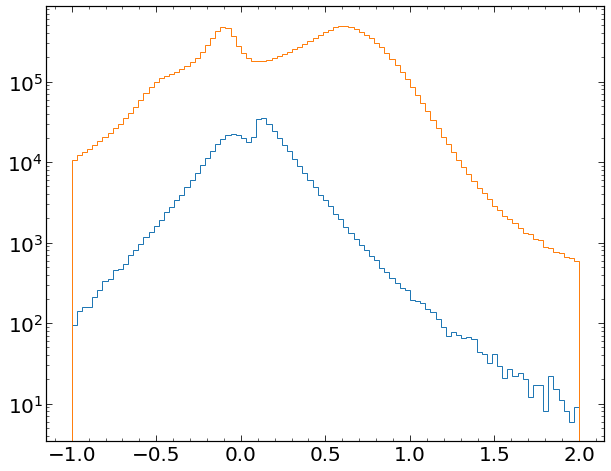

In [25]:
plt.hist(df_nan[(df_nan['cluster_label']=='star') & (df_nan['class']=='galaxy')]['mag_j_tot'] - 
         df_nan[(df_nan['cluster_label']=='star') & (df_nan['class']=='galaxy')]['mag_k_tot'],
         histtype='step',bins=np.linspace(-1,2,100))
plt.hist(df_nan['mag_j_tot'] - df_nan['mag_k_tot'],
         histtype='step',bins=np.linspace(-1,2,100))
plt.yscale('log')
plt.show()

In [34]:
r_mag_bins_1000=np.linspace(9,25,1000)

def jk_criteria(r):
    if r<19.5:
        return 0.025
    if r>19.5:
        return 0.025 + 0.025*(r - 19.5)
    
def jk_criteria2(r):
    if r<19.5:
        return 0.025
    if r>19.5:
        return 0.025 - 0.1*(r - 19.5)**2
    
seeing=np.median(df_nan['log10seeing'])

def rad_criteria(r):
    return seeing + 0.05 - 0.075*(r-20.5)

def rad_criteria_2(r):
    if r>20.5:
        return seeing + 0.05

In [35]:
seeing

-0.197727780190108

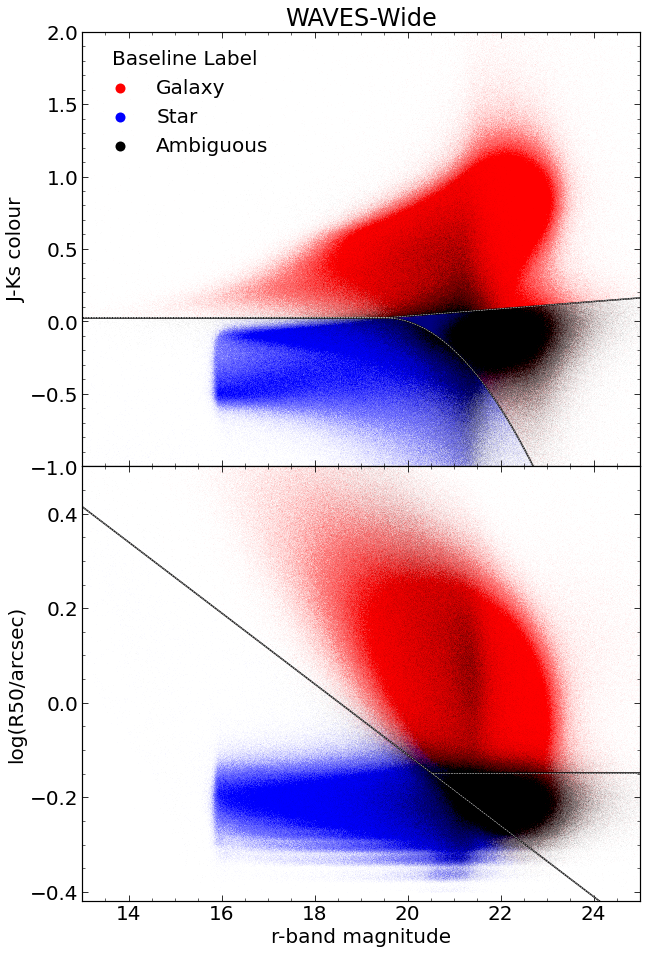

In [36]:
fig, axs = plt.subplots(2, 1, sharex=True,figsize=(10,16))
fig.subplots_adjust(hspace=0)

axs[0].scatter(df_nan[df_nan['class']=='galaxy']['mag_r_tot'],
            df_nan[df_nan['class']=='galaxy']['mag_j_tot']-df_nan[df_nan['class']=='galaxy']['mag_k_tot'],
            color='red',linewidth=0,s=0.01,label='Galaxy')
axs[0].scatter(df_nan[df_nan['class']=='star']['mag_r_tot'],
            df_nan[df_nan['class']=='star']['mag_j_tot']-df_nan[df_nan['class']=='star']['mag_k_tot'],
            color='blue',linewidth=0,s=0.01,label='Star')
axs[0].scatter(df_nan[df_nan['class']=='ambiguous']['mag_r_tot'],
            df_nan[df_nan['class']=='ambiguous']['mag_j_tot']-df_nan[df_nan['class']=='ambiguous']['mag_k_tot'],
            color='k',linewidth=0,s=0.01,label='Ambiguous')



axs[0].plot(r_mag_bins_1000,list(map(jk_criteria, r_mag_bins_1000)),c='k')
axs[0].plot(r_mag_bins_1000,list(map(jk_criteria2, r_mag_bins_1000)),c='k')

axs[0].plot(r_mag_bins_1000,list(map(jk_criteria, r_mag_bins_1000)),
                                 c='white',linestyle='dashed',linewidth=0.5)
axs[0].plot(r_mag_bins_1000,list(map(jk_criteria2, r_mag_bins_1000)),
                                 c='white',linestyle='dashed',linewidth=0.5)



lgnd=axs[0].legend(frameon=False,loc='upper left',title='Baseline Label')

lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]

axs[0].set_xlim(13,25)
axs[0].set_ylim(-1,2)
#plt.xlabel('r-band magnitude')
axs[0].set_ylabel('J-Ks colour')




axs[1].scatter(df_nan[df_nan['class']=='galaxy']['mag_r_tot'],
            np.log10(df_nan[df_nan['class']=='galaxy']['R50']),color='red',linewidth=0,s=0.01)
axs[1].scatter(df_nan[df_nan['class']=='star']['mag_r_tot'],
            np.log10(df_nan[df_nan['class']=='star']['R50']),color='blue',linewidth=0,s=0.01)
axs[1].scatter(df_nan[df_nan['class']=='ambiguous']['mag_r_tot'],
            np.log10(df_nan[df_nan['class']=='ambiguous']['R50']),color='k',linewidth=0,s=0.01)



axs[1].plot(r_mag_bins_1000,list(map(rad_criteria, r_mag_bins_1000)),c='k')
axs[1].plot(r_mag_bins_1000,list(map(rad_criteria_2, r_mag_bins_1000)),c='k')

axs[1].plot(r_mag_bins_1000,list(map(rad_criteria, r_mag_bins_1000)),
         c='white',linestyle='dashed',linewidth=0.5)
axs[1].plot(r_mag_bins_1000,list(map(rad_criteria_2, r_mag_bins_1000)),
         c='white',linestyle='dashed',linewidth=0.5)

axs[1].set_xlim(13,25)
axs[1].set_ylim(-0.42,0.5)

axs[1].set_xlabel('r-band magnitude')
axs[1].set_ylabel('log(R50/arcsec)')
axs[0].set_title('WAVES-Wide')


#plt.savefig('paper_plots/r_j-k_r50.jpg',bbox_inches='tight',dpi=500)



plt.show()

In [37]:
9958936/len(df_nan)

0.6656288609011212

(array([9958936.,       0.,       0.,       0.,       0., 4981788.,
              0.,       0.,       0.,   20971.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

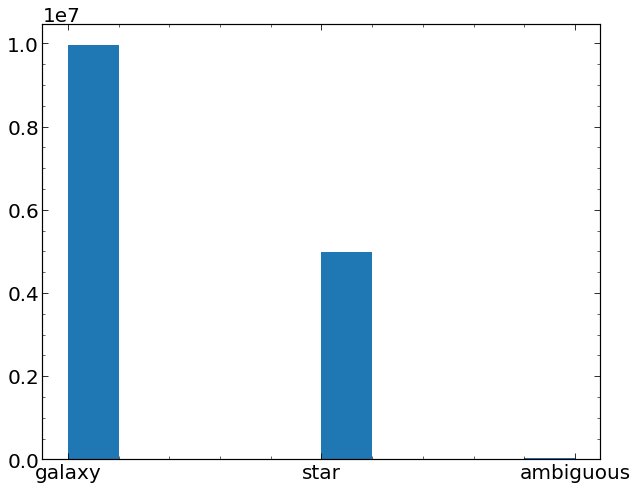

In [38]:
plt.hist(df_nan['cluster_label'])

In [18]:
df_nan['SB']=8.9-2.5*np.log10(df_nan['flux_Zt']/(np.pi*df_nan['R50']**2 * df_nan['axrat']))

/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
hdul = fits.open('../zall-tilecumulative-edr-vac.fits')
data = hdul[1].data
cols = hdul[1].columns
t=Table(data)
names = [name for name in t.colnames if len(t[name].shape) <= 1]
df_desi=t[names].to_pandas()
del hdul
del data
del cols
del t

In [20]:
df_desi=(df_desi[(df_desi['ZWARN']==0) & (df_desi['OBJTYPE']=='TGT')])

In [21]:
list(df_desi.columns)

['TARGETID',
 'SURVEY',
 'PROGRAM',
 'LASTNIGHT',
 'SPGRPVAL',
 'Z',
 'ZERR',
 'ZWARN',
 'CHI2',
 'NPIXELS',
 'SPECTYPE',
 'SUBTYPE',
 'NCOEFF',
 'DELTACHI2',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION',
 'FIBER',
 'COADD_FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'REF_EPOCH',
 'LAMBDA_REF',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'RELEASE',
 'BRICKNAME',
 'BRICKID',
 'BRICK_OBJID',
 'MORPHTYPE',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'MASKBITS',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'REF_ID',
 'REF_CAT',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_MAG',
 'PARALLAX',
 'PHOTSYS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'CMX_TARGET',
 'DESI_TARGET

/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


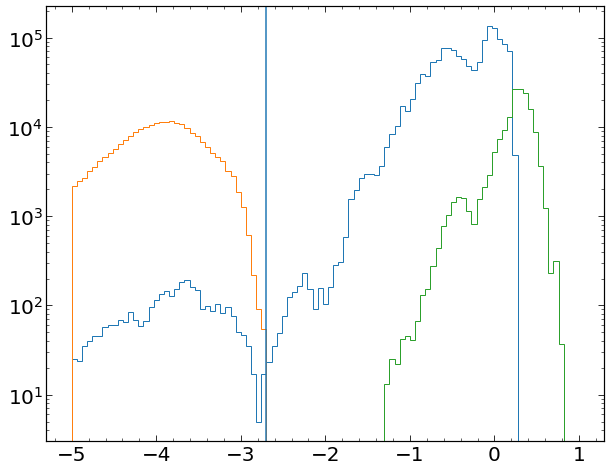

In [22]:
plt.hist(np.log10(df_desi[(df_desi['SPECTYPE']=='GALAXY')]['Z']),
         bins=np.linspace(-5,1,100),histtype='step')
plt.hist(np.log10(df_desi[(df_desi['SPECTYPE']=='STAR')]['Z']),
         bins=np.linspace(-5,1,100),histtype='step')
plt.hist(np.log10(df_desi[(df_desi['SPECTYPE']=='QSO')]['Z']),
         bins=np.linspace(-5,1,100),histtype='step')
plt.axvline(np.log10(0.002))
plt.yscale('log')
plt.show()

In [23]:
from astropy.coordinates import SkyCoord
import astropy.units as u

max_sep=0.6*u.arcsec
waves = SkyCoord(ra=df_nan['RAmax'].values*u.degree, dec=df_nan['Decmax'].values*u.degree)
desi = SkyCoord(ra=df_desi['TARGET_RA'].values*u.degree, dec=df_desi['TARGET_DEC'].values*u.degree)
idx, d2d, d3d = waves.match_to_catalog_sky(desi)
sep_constraint = d2d < max_sep
desi_matches=df_nan.iloc[sep_constraint]
desi_waves_matches=df_desi.iloc[idx[sep_constraint]]

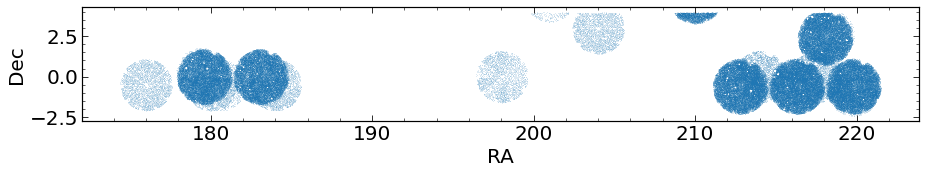

In [24]:
plt.figure(figsize=(15,10))
plt.scatter(desi_matches['RAmax'],
            desi_matches['Decmax'],linewidth=0,s=0.1)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('RA')
plt.ylabel('Dec')
#plt.savefig('plots/DESI_ra_dec.jpg',bbox_inches='tight',dpi=200)
#plt.xlim(209,213)
#plt.ylim(-2,2)
#plt.clim(0,0.6)
plt.show()

In [25]:
desi_matches['spec_class'] = desi_waves_matches['SPECTYPE'].values
desi_matches['Z'] = desi_waves_matches['Z'].values
desi_matches['Zwarn'] = desi_waves_matches['ZWARN'].values
desi_matches['chi2'] = desi_waves_matches['CHI2'].values
desi_matches['RA_survey'] = desi_waves_matches['TARGET_RA'].values
desi_matches['Dec_survey'] = desi_waves_matches['TARGET_DEC'].values
desi_matches['morph'] = desi_waves_matches['MORPHTYPE'].values

/tmp/ipykernel_1122/805910955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desi_matches['spec_class'] = desi_waves_matches['SPECTYPE'].values
/tmp/ipykernel_1122/805910955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desi_matches['Z'] = desi_waves_matches['Z'].values
/tmp/ipykernel_1122/805910955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

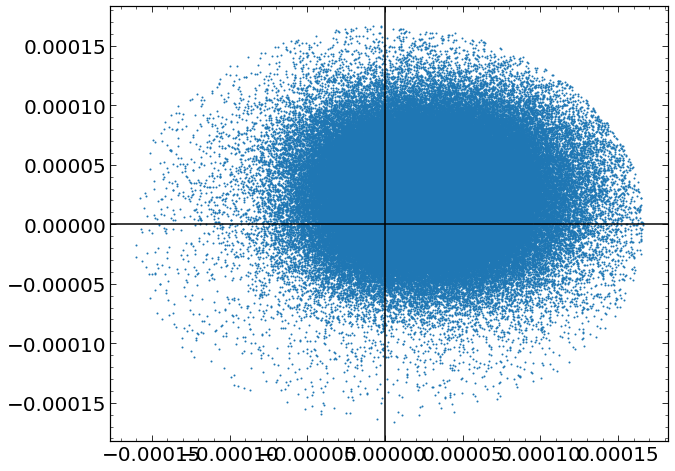

In [26]:
plt.scatter(desi_matches['RAmax']-desi_matches['RA_survey'],
           desi_matches['Decmax']-desi_matches['Dec_survey'],s=1)
plt.axhline(0,c='k')
plt.axvline(0,c='k')


In [27]:
desi_matches.loc[desi_matches[desi_matches['spec_class']=='GALAXY'].index,'spec_class']='galaxy'
desi_matches.loc[desi_matches[desi_matches['spec_class']=='STAR'].index,'spec_class']='star'
desi_matches.loc[desi_matches[desi_matches['spec_class']=='QSO'].index,'spec_class']='qso'

desi_matches.loc[desi_matches[desi_matches['Z']<0.0015].index,'spec_class']='star'

In [28]:
desi_matches=desi_matches.drop(desi_matches[(desi_matches['Z']<0.0015) & 
                                            (desi_matches['spec_class']=='galaxy')].index)

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [30]:
hdul = fits.open('../gkvScienceCatv02.fits')
data = hdul[1].data
cols = hdul[1].columns
t=Table(data)

df_gama=t.to_pandas().set_index('uberID')

df_gama=df_gama[df_gama['duplicate']==False]

df_gama=df_gama[df_gama['starmask']==False]
df_gama['mag_r_tot']=8.9-2.5*np.log10(df_gama['flux_rt'])

df_gama=df_gama[df_gama['NQ']>2]

In [31]:
df_gama.loc[df_gama[df_gama['RAmax']>300].index,'RAmax']=df_gama[df_gama['RAmax']>300]['RAmax']-360

In [32]:
hdul = fits.open('../StellarMassesGKVv24.fits')
data = hdul[1].data
cols = hdul[1].columns
t=Table(data)
names = [name for name in t.colnames if len(t[name].shape) <= 1]
gama_sm=t[names].to_pandas().set_index('uberID')
del hdul
del data
del cols
del t

In [33]:
df_gama['mstar']=np.nan
intersect=np.intersect1d(df_gama.index,gama_sm.index)
df_gama.loc[intersect,'mstar'] = gama_sm.loc[intersect]['mstar']

In [34]:
from astropy.coordinates import SkyCoord
import astropy.units as u

max_sep=0.6*u.arcsec
waves = SkyCoord(ra=df_nan['RAmax'].values*u.degree, dec=df_nan['Decmax'].values*u.degree)
gama = SkyCoord(ra=df_gama['RAmax'].values*u.degree, dec=df_gama['Decmax'].values*u.degree)
idx, d2d, d3d = waves.match_to_catalog_sky(gama)
sep_constraint = d2d < max_sep
waves_matches=df_nan.iloc[sep_constraint]
gama_matches=df_gama.iloc[idx[sep_constraint]]
len(gama_matches)

197920

In [35]:
waves_matches['uberclass']=gama_matches['uberclass'].values
waves_matches['NQ']=gama_matches['NQ'].values
waves_matches['Z']=gama_matches['Z'].values
waves_matches['mstar']=gama_matches['mstar'].values
waves_matches['RA_survey']=gama_matches['RAmax'].values
waves_matches['Dec_survey']=gama_matches['Decmax'].values

/tmp/ipykernel_1122/536352505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waves_matches['uberclass']=gama_matches['uberclass'].values
/tmp/ipykernel_1122/536352505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waves_matches['NQ']=gama_matches['NQ'].values
/tmp/ipykernel_1122/536352505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

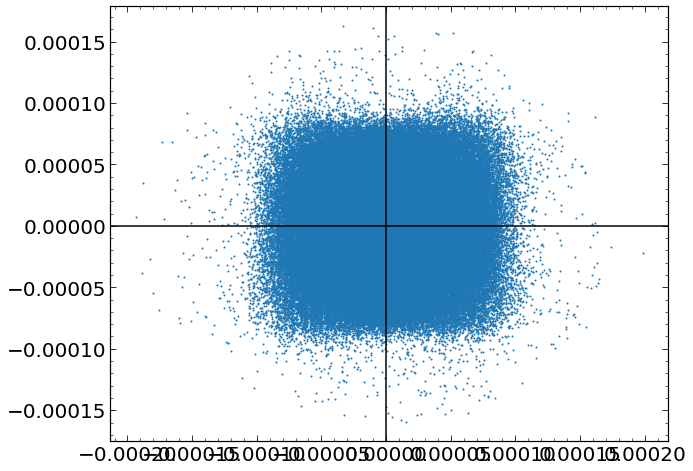

In [36]:
plt.scatter(waves_matches['RAmax']-waves_matches['RA_survey'],
           waves_matches['Decmax']-waves_matches['Dec_survey'],s=1)
plt.axhline(0,c='k')
plt.axvline(0,c='k')


In [37]:
waves_matches['spec_class']=waves_matches['uberclass']

/tmp/ipykernel_1122/123155539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waves_matches['spec_class']=waves_matches['uberclass']


In [38]:
waves_matches['spec_class']=waves_matches['spec_class'].replace([1], 'galaxy')
waves_matches['spec_class']=waves_matches['spec_class'].replace([2], 'star')
waves_matches['spec_class']=waves_matches['spec_class'].replace([3], 'ambiguous')

/tmp/ipykernel_1122/2131582609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waves_matches['spec_class']=waves_matches['spec_class'].replace([1], 'galaxy')
/tmp/ipykernel_1122/2131582609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waves_matches['spec_class']=waves_matches['spec_class'].replace([2], 'star')
/tmp/ipykernel_1122/2131582609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [39]:
hdul = fits.open('../GAIA_S1.fits')
data = hdul[1].data
cols = hdul[1].columns
t=Table(data)

dfgaia1=t.to_pandas()
del data
del cols
del t

In [40]:
hdul = fits.open('../GAIA_S2.fits')
data = hdul[1].data
cols = hdul[1].columns
t=Table(data)

dfgaia2=t.to_pandas()
del data
del cols
del t

In [41]:
hdul = fits.open('../GAIA_N.fits')
data = hdul[1].data
cols = hdul[1].columns
t=Table(data)

dfgaia3=t.to_pandas()
del data
del cols
del t

In [42]:
dfgaia=pd.concat([dfgaia1,dfgaia2,dfgaia3]).set_index('source_id')

In [43]:
dfgaia.loc[dfgaia[dfgaia['ra']>300].index,'ra'] = dfgaia[dfgaia['ra']>300]['ra']-360

In [44]:
from astropy.coordinates import SkyCoord
import astropy.units as u

max_sep=0.6*u.arcsec
waves = SkyCoord(ra=df_nan['RAmax'].values*u.degree, dec=df_nan['Decmax'].values*u.degree)
gaia = SkyCoord(ra=dfgaia['ra'].values*u.degree, dec=dfgaia['dec'].values*u.degree)
idx, d2d, d3d = waves.match_to_catalog_sky(gaia)
sep_constraint = d2d < max_sep
gaia_matches=df_nan.iloc[sep_constraint]
gaia_waves_matches = dfgaia.iloc[idx[sep_constraint]]

In [45]:
gaia_matches=pd.concat([gaia_matches.reset_index(),gaia_waves_matches.reset_index()],axis=1)

In [46]:
gaia_matches=gaia_matches.set_index('uberID')

In [47]:
gaia_matches['RA_survey']=gaia_waves_matches['ra'].values
gaia_matches['Dec_survey']=gaia_waves_matches['dec'].values

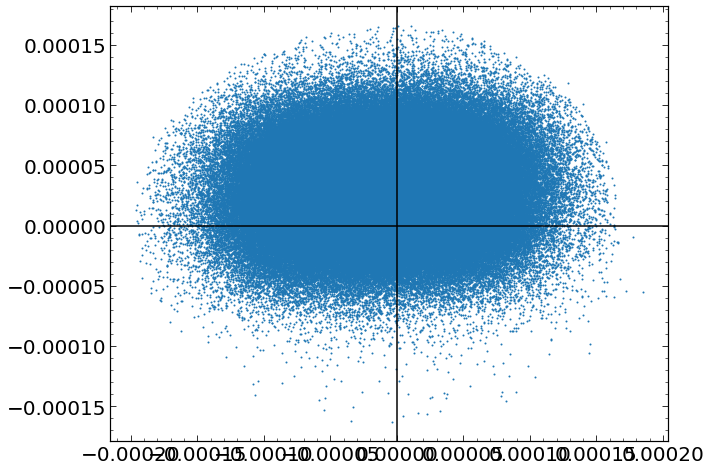

In [48]:
plt.scatter(gaia_matches['RAmax']-gaia_matches['RA_survey'],
           gaia_matches['Decmax']-gaia_matches['Dec_survey'],s=1)
plt.axhline(0,c='k')
plt.axvline(0,c='k')


In [49]:
#gaia_smol=gaia_matches[['RAmax','Decmax','mag_z_tot','RAGAIA','DecGAIA','phot_g_mean_mag','phot_rp_mean_mag','parallax','parallax_error']]

In [50]:
#gaia_smol.to_csv('WAVES_wide_gaia_stars.csv')

In [51]:
df_sdss=pd.read_csv('../SDSS.csv')

In [52]:
from astropy.coordinates import SkyCoord
import astropy.units as u

max_sep=0.6*u.arcsec
waves = SkyCoord(ra=df_nan['RAmax'].values*u.degree, dec=df_nan['Decmax'].values*u.degree)
sdss = SkyCoord(ra=df_sdss['PLUG_RA'].values*u.degree, dec=df_sdss['PLUG_DEC'].values*u.degree)
idx, d2d, d3d = waves.match_to_catalog_sky(sdss)
sep_constraint = d2d < max_sep
sdss_matches=df_nan.iloc[sep_constraint]
sdss_waves_matches = df_sdss.iloc[idx[sep_constraint]]

In [53]:
np.unique(sdss_waves_matches['SURVEY'])

array(['boss  ', 'sdss  ', 'segue1', 'segue2'], dtype=object)

In [54]:
len(sdss_waves_matches[sdss_waves_matches['SURVEY']=='sdss  '])/len(sdss_waves_matches)

0.4166349921057248

In [55]:
sdss_matches['spec_class']=sdss_waves_matches['CLASS'].values
sdss_matches['Z']=sdss_waves_matches['Z'].values
sdss_matches['survey']=sdss_waves_matches['SURVEY'].values
sdss_matches['RA_survey']=sdss_waves_matches['PLUG_RA'].values
sdss_matches['Dec_survey']=sdss_waves_matches['PLUG_DEC'].values

/tmp/ipykernel_1122/2791716038.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdss_matches['spec_class']=sdss_waves_matches['CLASS'].values
/tmp/ipykernel_1122/2791716038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdss_matches['Z']=sdss_waves_matches['Z'].values
/tmp/ipykernel_1122/2791716038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

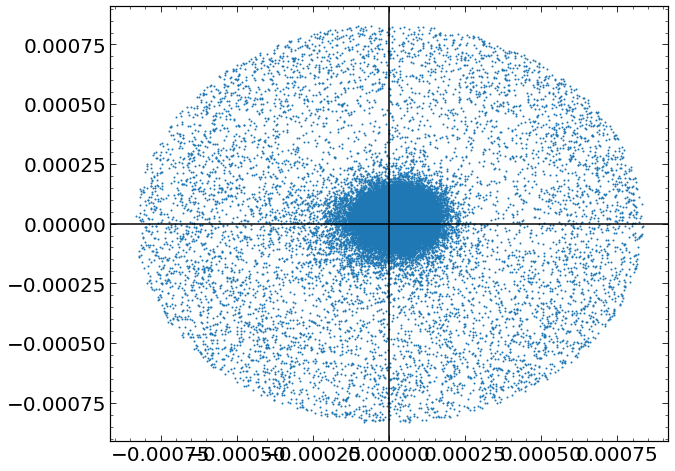

In [565]:
plt.scatter(sdss_matches['RAmax']-sdss_matches['RA_survey'],
           sdss_matches['Decmax']-sdss_matches['Dec_survey'],s=1)
plt.axhline(0,c='k')
plt.axvline(0,c='k')

In [566]:
np.unique(sdss_matches['spec_class'])

array(['GALAXY', 'QSO   ', 'STAR  '], dtype=object)

In [567]:
sdss_matches.loc[sdss_matches[sdss_matches['spec_class']=='GALAXY'].index,'spec_class']='galaxy'
sdss_matches.loc[sdss_matches[sdss_matches['spec_class']=='STAR  '].index,'spec_class']='star'
sdss_matches.loc[sdss_matches[sdss_matches['spec_class']=='QSO   '].index,'spec_class']='qso'

In [568]:
df_test=df_nan[(df_nan['Decmax']>-20) & (df_nan['R50']>0)]
percentile=np.percentile(np.log10(df_test['R50'])-df_test['log10seeing'],5)
df_lim=df_test[(np.log10(df_test['R50'])-df_nan['log10seeing'])<percentile]

/tmp/ipykernel_64430/2731309998.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_lim=df_test[(np.log10(df_test['R50'])-df_nan['log10seeing'])<percentile]


In [569]:
percentile

-0.05561316193987064

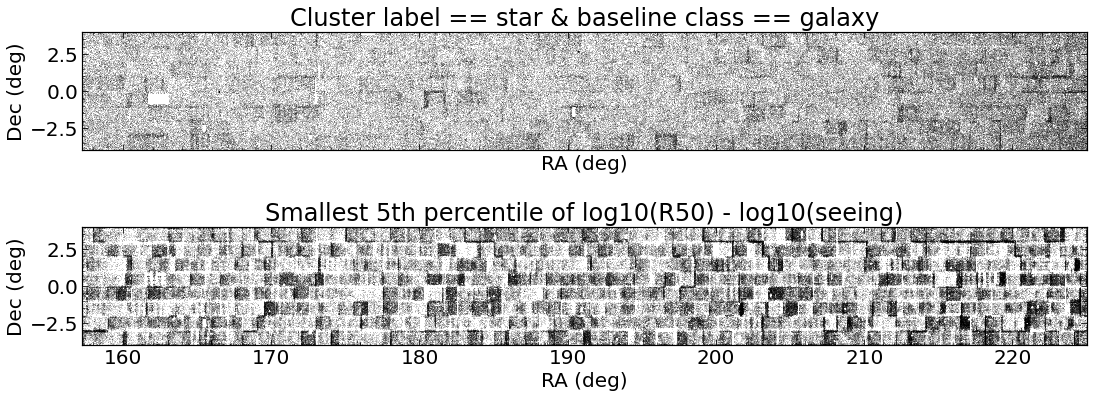

In [570]:
fig, axs = plt.subplots(2, 1, sharex=True,figsize=(18,7))
fig.subplots_adjust(hspace=0.05)

axs[0].scatter(df_nan[((df_nan['cluster_label']=='star')|(df_nan['cluster_label']=='ambiguous')) & 
                      (df_nan['class']=='galaxy')]['RAmax'],
               df_nan[((df_nan['cluster_label']=='star')|(df_nan['cluster_label']=='ambiguous')) & 
                      (df_nan['class']=='galaxy')]['Decmax'],
               linewidth=0,s=0.1,c='k')
axs[0].set_xlim(157.25,225)
axs[0].set_ylim(-4,4)
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_title('Cluster label == star & baseline class == galaxy')
axs[0].set_xlabel('RA (deg)')
axs[0].set_ylabel('Dec (deg)')


axs[1].scatter(df_lim['RAmax'],
               df_lim['Decmax'],
               linewidth=0,s=0.1,c='k')
axs[1].set_xlim(157.25,225)
axs[1].set_ylim(-4,4)
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_title('Smallest 5th percentile of log10(R50) - log10(seeing)')
axs[1].set_xlabel('RA (deg)')
axs[1].set_ylabel('Dec (deg)')


#plt.savefig('tiling.jpg',bbox_inches='tight',dpi=500)

plt.show()

In [571]:
waves_matches['gama_spec_class']=waves_matches['spec_class']
desi_matches['desi_spec_class']=desi_matches['spec_class']
sdss_matches['sdss_spec_class']=sdss_matches['spec_class']
gaia_matches['spec_class']='star'
gaia_matches['gaia_spec_class']=gaia_matches['spec_class']

/tmp/ipykernel_64430/653069164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waves_matches['gama_spec_class']=waves_matches['spec_class']
/tmp/ipykernel_64430/653069164.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdss_matches['sdss_spec_class']=sdss_matches['spec_class']


In [572]:
stars=pd.concat([waves_matches[waves_matches['spec_class']=='star'],
                desi_matches[desi_matches['spec_class']=='star'],
                sdss_matches[sdss_matches['spec_class']=='star'],
                gaia_matches])

In [573]:
galaxies=pd.concat([waves_matches[waves_matches['spec_class']=='galaxy'],
                    desi_matches[desi_matches['spec_class']=='galaxy'],
                   sdss_matches[sdss_matches['spec_class']=='galaxy']])

In [574]:
total=pd.concat([stars,galaxies])

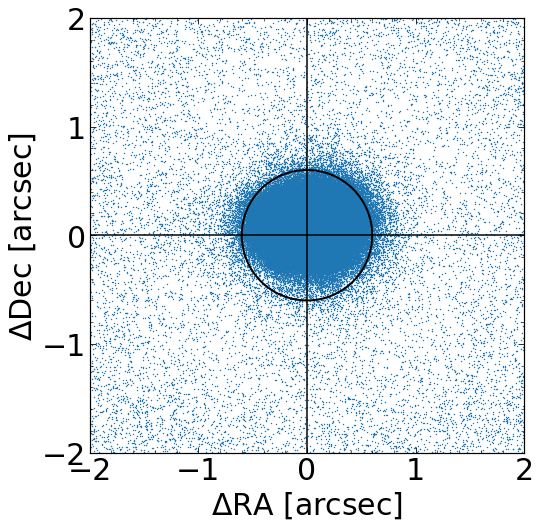

In [575]:
plt.rcParams['figure.figsize'] = [10,8]
font = {'size'   : 30}
plt.rc('font', **font)

#circle1 = plt.Circle((0,0), 1.2, color='k', fill=False)
circle2 = plt.Circle((0,0), 0.6, color='k', fill=False,linewidth=2)
    
ax = plt.gca()
ax.cla() # clear things for fresh plot

#ax.add_patch(circle1)


ax.scatter(total['RAmax']*3600-total['RA_survey']*3600,
           total['Decmax']*3600-total['Dec_survey']*3600,s=2,linewidth=0)
ax.add_patch(circle2)

ax.axhline(0,c='k')
ax.axvline(0,c='k')
ax.set_aspect('equal', 'box')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel(r'$\Delta$'+'RA [arcsec]')
plt.ylabel(r'$\Delta$'+'Dec [arcsec]')
#plt.text(-1.4,1.2,r'$\Delta$'+' RA: '+str(round(np.mean(total['RAmax']*3600-total['RA_survey']*3600),3)))
#plt.text(-1.4,1,r'$\Delta$'+' Dec: '+str(round(np.mean(total['Decmax']*3600-total['Dec_survey']*3600),3)))
plt.savefig('cross_match.jpg',bbox_inches='tight',dpi=100)
plt.show()

plt.rcParams['figure.figsize'] = [10,8]
font = {'size'   : 20}
plt.rc('font', **font)

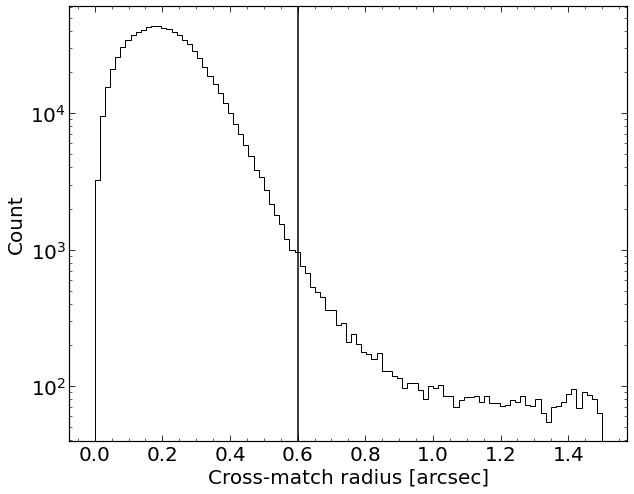

In [576]:


plt.hist(np.sqrt((total['RAmax']*3600-total['RA_survey']*3600)**2 + 
        (total['Decmax']*3600-total['Dec_survey']*3600)**2),bins=np.linspace(0,1.5,100),histtype='step',color='k')
plt.yscale('log')
plt.axvline(0.6,c='k')
plt.xlabel('Cross-match radius [arcsec]')
plt.ylabel('Count')
plt.savefig('cross_match_hist.jpg',bbox_inches='tight',dpi=100)
plt.show()


In [577]:
bins=np.linspace(14,21.2,50)

In [578]:
desi_gals=desi_matches[desi_matches['spec_class']=='galaxy']
desi_stars=desi_matches[desi_matches['spec_class']=='star']
gama_gals=waves_matches[waves_matches['spec_class']=='galaxy']
gama_stars=waves_matches[waves_matches['spec_class']=='star']
sdss_gals=sdss_matches[sdss_matches['spec_class']=='galaxy']
sdss_stars=sdss_matches[sdss_matches['spec_class']=='star']

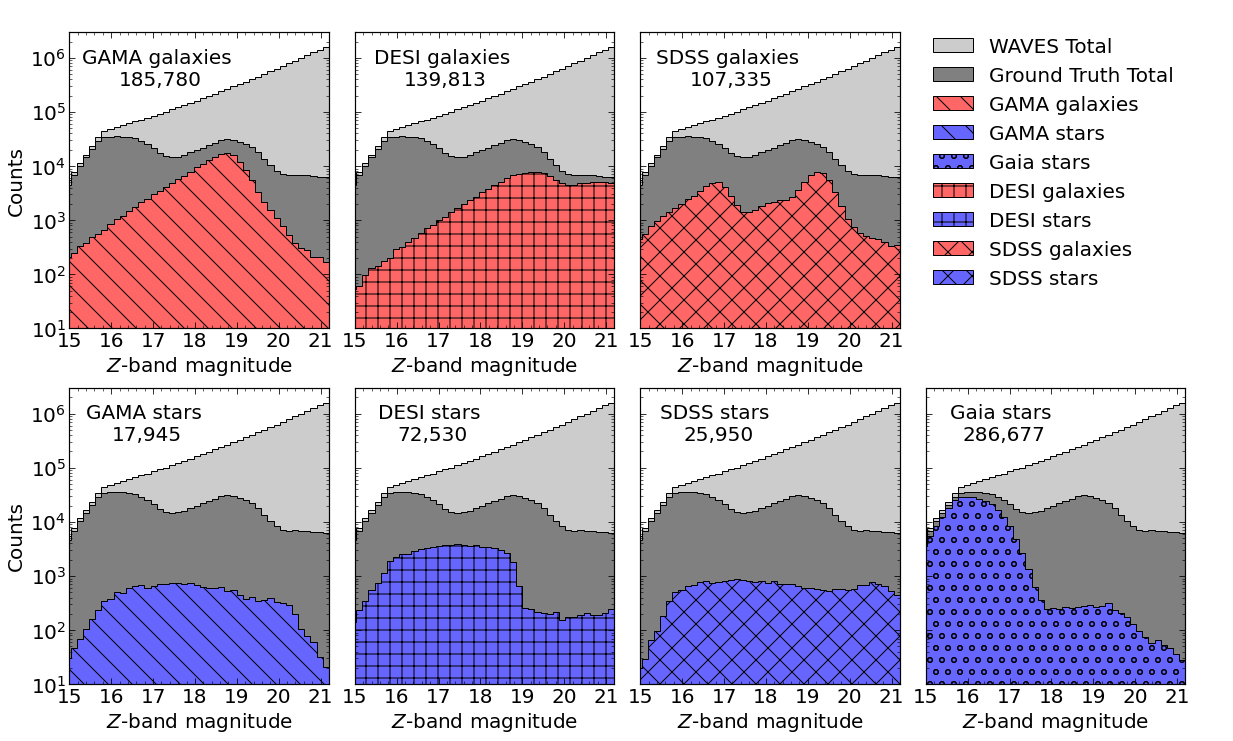

In [579]:
fig = plt.figure(figsize=(20,12))
spec = matplotlib.gridspec.GridSpec(ncols=4, nrows=2) # 6 columns evenly divides both 2 & 3
plt.subplots_adjust(wspace=0.1)
ax1 = fig.add_subplot(spec[0,0]) 
ax2 = fig.add_subplot(spec[1,0])
ax3 = fig.add_subplot(spec[1,3])
ax4 = fig.add_subplot(spec[0,1]) 
ax5 = fig.add_subplot(spec[1,1])
ax6 = fig.add_subplot(spec[0,2]) 
ax7 = fig.add_subplot(spec[1,2])

ax1.hist(df_nan['mag_z_tot'],histtype='stepfilled',bins=bins,color=(0.8,0.8,0.8),edgecolor='k',label='WAVES Total')
ax1.hist(total['mag_z_tot'],
         histtype='stepfilled',color=(0.5,0.5,0.5),bins=bins,edgecolor='k',label='Ground Truth Total')
ax1.hist(waves_matches[waves_matches['spec_class']=='galaxy']['mag_z_tot'],
                       histtype='stepfilled',color=(1,0.4,0.4),bins=bins,hatch='\\',edgecolor='k',label='GAMA galaxies')
ax1.set_yscale('log')
ax1.set_ylim(10,3000000)
ax1.set_xlim(15,21.2)
ax1.set_xticks([15,16,17,18,19,20,21])
ax1.set_xlabel(r'$Z$-band magnitude')
ax1.set_ylabel('Counts')
ax1.set_title('GAMA galaxies \n'+str("{:,}".format(len(gama_gals))),fontsize=20,x=0.35,y=0.8)




ax2.hist(df_nan['mag_z_tot'],histtype='stepfilled',bins=bins,color=(0.8,0.8,0.8),edgecolor='k')
ax2.hist(total['mag_z_tot'],
         histtype='stepfilled',color=(0.5,0.5,0.5),bins=bins,edgecolor='k')
ax2.hist(waves_matches[waves_matches['spec_class']=='star']['mag_z_tot'],
                       histtype='stepfilled',color=(0.4,0.4,1),bins=bins,hatch='\\',edgecolor='k',label='GAMA stars')

ax2.set_yscale('log')
ax2.set_ylim(10,3000000)
ax2.set_xlim(15,21.2)
ax2.set_xticks([15,16,17,18,19,20,21])
ax2.set_xlabel(r'$Z$-band magnitude')
ax2.set_ylabel('Counts')
ax2.set_title('GAMA stars \n'+str("{:,}".format(len(gama_stars))),fontsize=20,x=0.3,y=0.8)





ax4.hist(df_nan['mag_z_tot'],histtype='stepfilled',bins=bins,color=(0.8,0.8,0.8),edgecolor='k')
ax4.hist(total['mag_z_tot'],
         histtype='stepfilled',color=(0.5,0.5,0.5),bins=bins,edgecolor='k')
ax4.hist(desi_matches[desi_matches['spec_class']=='galaxy']['mag_z_tot'],
                       histtype='stepfilled',color=(1,0.4,0.4),bins=bins,hatch='+',edgecolor='k',label='DESI galaxies')

ax4.set_yscale('log')
ax4.set_ylim(10,3000000)
ax4.set_xlim(15,21.2)
ax4.set_xticks([15,16,17,18,19,20,21])
ax4.set_xlabel(r'$Z$-band magnitude')
ax4.set_xticks([15,16,17,18,19,20,21])
ax4.set_yticklabels([])
ax4.set_title('DESI galaxies \n'+str("{:,}".format(len(desi_gals))),fontsize=20,x=0.35,y=0.8)




ax5.hist(df_nan['mag_z_tot'],histtype='stepfilled',bins=bins,color=(0.8,0.8,0.8),edgecolor='k')
ax5.hist(total['mag_z_tot'],
         histtype='stepfilled',color=(0.5,0.5,0.5),bins=bins,edgecolor='k')
ax5.hist(desi_matches[desi_matches['spec_class']=='star']['mag_z_tot'],
                       histtype='stepfilled',color=(0.4,0.4,1),bins=bins,hatch='+',edgecolor='k',label='DESI stars')

ax5.set_yscale('log')
ax5.set_ylim(10,3000000)
ax5.set_xticks([15,16,17,18,19,20,21])
ax5.set_xlim(15,21.2)
ax5.set_yticklabels([])
ax5.set_xlabel(r'$Z$-band magnitude')
ax5.set_title('DESI stars \n'+str("{:,}".format(len(desi_stars))),fontsize=20,x=0.3,y=0.8)


ax3.hist(df_nan['mag_z_tot'],histtype='stepfilled',bins=bins,color=(0.8,0.8,0.8),edgecolor='k')
ax3.hist(total['mag_z_tot'],
         histtype='stepfilled',color=(0.5,0.5,0.5),bins=bins,edgecolor='k')
ax3.set_yscale('log')
ax3.hist(gaia_matches['mag_z_tot'],
                      histtype='stepfilled',color=(0.4,0.4,1),bins=bins,hatch='o',edgecolor='k',label='Gaia stars')

ax3.set_yticklabels([])
ax3.set_xlim(15,21.2)
ax3.set_ylim(10,3000000)
ax3.set_xticks([15,16,17,18,19,20,21])
ax3.set_xlabel(r'$Z$-band magnitude')
ax3.set_title('Gaia stars \n'+str("{:,}".format(len(gaia_matches))),fontsize=20,x=0.3,y=0.8)




ax6.hist(df_nan['mag_z_tot'],histtype='stepfilled',bins=bins,color=(0.8,0.8,0.8),edgecolor='k')
ax6.hist(total['mag_z_tot'],
         histtype='stepfilled',color=(0.5,0.5,0.5),bins=bins,edgecolor='k')
ax6.hist(sdss_matches[sdss_matches['spec_class']=='galaxy']['mag_z_tot'],
                       histtype='stepfilled',color=(1,0.4,0.4),bins=bins,hatch='x',edgecolor='k',label='SDSS galaxies')

ax6.set_yscale('log')
ax6.set_ylim(10,3000000)
ax6.set_xlim(15,21.2)
ax6.set_xticks([15,16,17,18,19,20,21])
ax6.set_xlabel(r'$Z$-band magnitude')
ax6.set_yticklabels([])
ax6.set_title('SDSS galaxies \n'+str("{:,}".format(len(sdss_gals))),fontsize=20,x=0.35,y=0.8)




ax7.hist(df_nan['mag_z_tot'],histtype='stepfilled',bins=bins,color=(0.8,0.8,0.8),edgecolor='k')
ax7.hist(total['mag_z_tot'],
         histtype='stepfilled',color=(0.5,0.5,0.5),bins=bins,edgecolor='k')
ax7.hist(sdss_matches[sdss_matches['spec_class']=='star']['mag_z_tot'],
                       histtype='stepfilled',color=(0.4,0.4,1),bins=bins,hatch='x',edgecolor='k',label='SDSS stars')

ax7.set_yscale('log')
ax7.set_ylim(10,3000000)
ax7.set_xlim(15,21.2)
ax7.set_yticklabels([])
ax7.set_xticks([15,16,17,18,19,20,21])
ax7.set_xlabel(r'$Z$-band magnitude')
ax7.set_title('SDSS stars \n'+str("{:,}".format(len(sdss_stars))),fontsize=20,x=0.3,y=0.8)

fig.legend(loc=(0.75,0.6),frameon=False)

plt.savefig('paper_plots/z_mag_count2.jpg',bbox_inches='tight',dpi=200)

plt.show()

In [580]:
df_total=pd.concat([gaia_matches,desi_gals,desi_stars,
                    gama_gals,gama_stars,sdss_gals,sdss_stars])

In [581]:
df_total=gaia_matches

In [582]:
contradict=np.intersect1d(df_total[df_total['spec_class']=='star'].index,sdss_gals.index)
print(len(contradict))
duplicate=np.intersect1d(df_total[df_total['spec_class']=='galaxy'].index,sdss_gals.index)
print(len(duplicate))
df_total=pd.concat([df_total.drop(contradict).drop(duplicate),sdss_gals.drop(contradict)])

13
0


In [583]:
contradict=np.intersect1d(df_total[df_total['spec_class']=='galaxy'].index,sdss_stars.index)
print(len(contradict))
duplicate=np.intersect1d(df_total[df_total['spec_class']=='star'].index,sdss_stars.index)
print(len(duplicate))
df_total=pd.concat([df_total.drop(contradict).drop(duplicate),sdss_stars.drop(contradict)])

0
1926


In [584]:
contradict=np.intersect1d(df_total[df_total['spec_class']=='star'].index,gama_gals.index)
print(len(contradict))
duplicate=np.intersect1d(df_total[df_total['spec_class']=='galaxy'].index,gama_gals.index)
print(len(duplicate))
df_total=pd.concat([df_total.drop(contradict).drop(duplicate),gama_gals.drop(contradict)])

84
23526


In [585]:
contradict=np.intersect1d(df_total[df_total['spec_class']=='galaxy'].index,gama_stars.index)
print(len(contradict))
duplicate=np.intersect1d(df_total[df_total['spec_class']=='star'].index,gama_stars.index)
print(len(duplicate))
df_total=pd.concat([df_total.drop(contradict).drop(duplicate),gama_stars.drop(contradict)])

39
8996


In [586]:
contradict=np.intersect1d(df_total[df_total['spec_class']=='star'].index,desi_gals.index)
print(len(contradict))
duplicate=np.intersect1d(df_total[df_total['spec_class']=='galaxy'].index,desi_gals.index)
print(len(duplicate))
df_total=pd.concat([df_total.drop(contradict).drop(duplicate),desi_gals.drop(contradict)])

176
58286


In [587]:
contradict=np.intersect1d(df_total[df_total['spec_class']=='galaxy'].index,desi_stars.index)
print(len(contradict))
duplicate=np.intersect1d(df_total[df_total['spec_class']=='star'].index,desi_stars.index)
print(len(duplicate))
df_total=pd.concat([df_total.drop(contradict).drop(duplicate),desi_stars.drop(contradict)])

156
15543


In [588]:
1467+22316+8486+55638+14997

102904

In [589]:
56+30+33+99

218

In [590]:
len(df_total[df_total['spec_class']=='star'])

376169

In [591]:
from scipy.ndimage.filters import gaussian_filter

In [592]:
gals=df_nan[df_nan['cluster_label']=='galaxy'][['mag_j_tot','mag_k_tot','mag_i_tot','mag_g_tot','mag_z_tot','R50']]
stars=df_nan[df_nan['cluster_label']=='star'][['mag_j_tot','mag_k_tot','mag_i_tot','mag_g_tot','mag_z_tot','R50']]


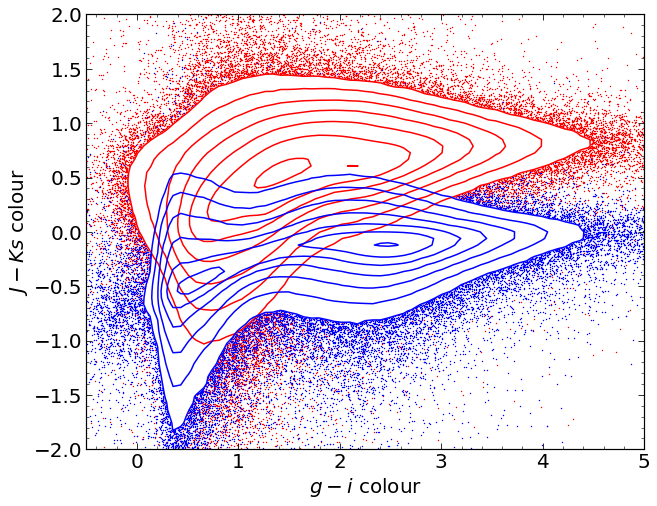

In [593]:
xlim=[-0.5,5]
ylim=[-2,2]
log=[2.5,5,8]
smooth=0.5

plt.scatter(gals['mag_g_tot'][::10]-gals['mag_i_tot'][::10],
            gals['mag_j_tot'][::10]-gals['mag_k_tot'][::10],
            s=2,c='red',label='Galaxies',linewidth=0)
plt.scatter(stars['mag_g_tot'][::10]-stars['mag_i_tot'][::10],
            stars['mag_j_tot'][::10]-stars['mag_k_tot'][::10],
            s=2,c='blue',label='Stars',linewidth=0)
z,x,y=np.histogram2d(gals['mag_g_tot']-gals['mag_i_tot'],
                     gals['mag_j_tot']-gals['mag_k_tot'], 
                     bins=(np.linspace(xlim[0]-1,xlim[1]+1,100),np.linspace(ylim[0]-1,ylim[1]+1,100)))
xcenters = (x[:-1] + x[1:]) / 2
ycenters = (y[:-1] + y[1:]) / 2
plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='red'
           ,levels=np.logspace(log[0],log[1],log[2]))
plt.contourf(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='w'
           ,levels=np.logspace(log[0],log[1],log[2]))

z,x,y=np.histogram2d(stars['mag_g_tot']-stars['mag_i_tot'],
                     stars['mag_j_tot']-stars['mag_k_tot'], 
                     bins=(np.linspace(xlim[0]-1,xlim[1]+1,100),np.linspace(ylim[0]-1,ylim[1]+1,100)))
xcenters = (x[:-1] + x[1:]) / 2
ycenters = (y[:-1] + y[1:]) / 2
plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='blue'
           ,levels=np.logspace(log[0],log[1],log[2]))
plt.contourf(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='w'
           ,levels=np.logspace(log[0],log[1],log[2]))


plt.xlim(xlim[0],xlim[1])
plt.ylim(ylim[0],ylim[1])
plt.xlabel(r'$g-i$'+' colour')
plt.ylabel(r'$J-Ks$'+' colour')

#plt.savefig('paper_plots/g-i_j-k_cluster.jpg',bbox_inches='tight',dpi=500)



plt.show()

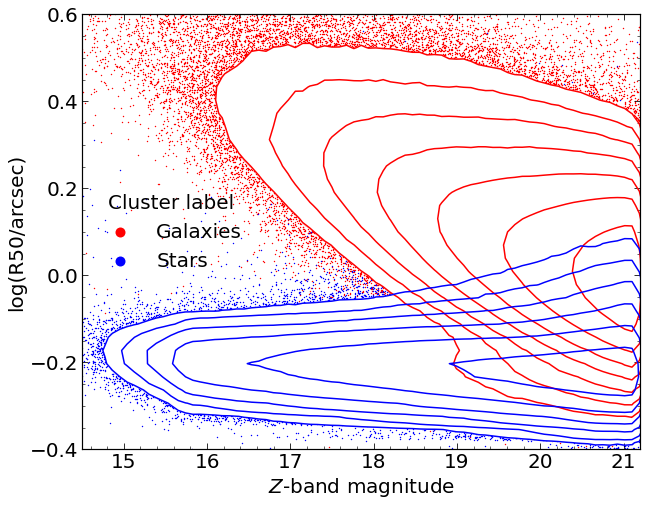

In [594]:
xlim=[14.5,21.2]
ylim=[-0.4,0.6]
log=[2.5,5,8]
smooth=0.5
plt.scatter(gals['mag_z_tot'][::10],np.log10(gals['R50'][::10]),s=2,linewidth=0,c='red',label='Galaxies')
plt.scatter(stars['mag_z_tot'][::10],np.log10(stars['R50'][::10]),s=2,linewidth=0,c='blue',label='Stars')
z,x,y=np.histogram2d(gals['mag_z_tot'],
                     np.log10(gals['R50']), 
                     bins=(np.linspace(xlim[0]-1,xlim[1]+1,100),np.linspace(ylim[0]-1,ylim[1]+1,100)))
xcenters = (x[:-1] + x[1:]) / 2
ycenters = (y[:-1] + y[1:]) / 2
plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='red'
           ,levels=np.logspace(log[0],log[1],log[2]))
plt.contourf(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='w'
           ,levels=np.logspace(log[0],log[1],log[2]))

z,x,y=np.histogram2d(stars['mag_z_tot'],
                     np.log10(stars['R50']), 
                     bins=(np.linspace(xlim[0]-1,xlim[1]+1,100),np.linspace(ylim[0]-1,ylim[1]+1,100)))
xcenters = (x[:-1] + x[1:]) / 2
ycenters = (y[:-1] + y[1:]) / 2
plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='blue'
           ,levels=np.logspace(log[0],log[1],log[2]))
plt.contourf(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='w'
           ,levels=np.logspace(log[0],log[1],log[2]))
plt.xlim(xlim[0],xlim[1])
plt.ylim(ylim[0],ylim[1])
plt.xlabel(r'$Z$'+'-band magnitude')
plt.ylabel('log(R50/arcsec)')

lgnd=plt.legend(frameon=False,loc='center left',title='Cluster label')

lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
#plt.savefig('paper_plots/z_r50_cluster.jpg',bbox_inches='tight',dpi=500)

plt.show()

In [595]:
gals=df_nan[df_nan['class']=='galaxy'][['mag_j_tot','mag_k_tot','mag_i_tot','mag_g_tot','mag_z_tot','R50']]
stars=df_nan[df_nan['class']=='star'][['mag_j_tot','mag_k_tot','mag_i_tot','mag_g_tot','mag_z_tot','R50']]
amb=df_nan[df_nan['class']=='ambiguous'][['mag_j_tot','mag_k_tot','mag_i_tot','mag_g_tot','mag_z_tot','R50']]

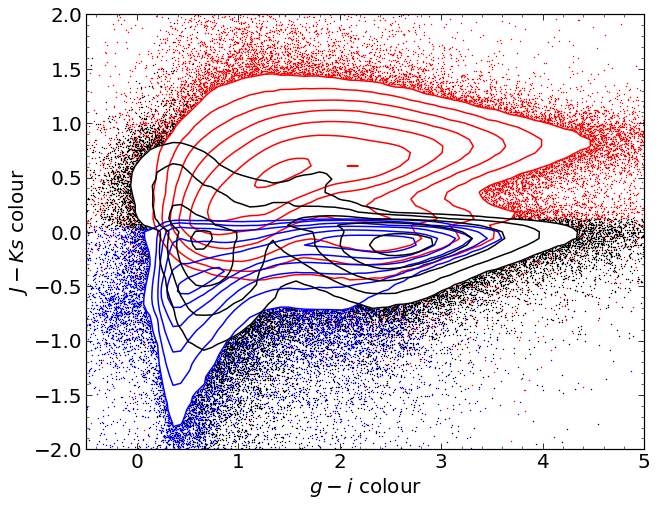

In [596]:
xlim=[-0.5,5]
ylim=[-2,2]
log=[2.5,5,8]
smooth=0.5
plt.scatter(gals['mag_g_tot'][::10]-gals['mag_i_tot'][::10],
            gals['mag_j_tot'][::10]-gals['mag_k_tot'][::10],
            s=2,c='red',label='Galaxies',linewidth=0)
plt.scatter(stars['mag_g_tot'][::10]-stars['mag_i_tot'][::10],
            stars['mag_j_tot'][::10]-stars['mag_k_tot'][::10],
            s=2,c='blue',label='Stars',linewidth=0)
plt.scatter(amb['mag_g_tot'][::10]-amb['mag_i_tot'][::10],
            amb['mag_j_tot'][::10]-amb['mag_k_tot'][::10],
            s=2,c='k',linewidth=0)
z,x,y=np.histogram2d(gals['mag_g_tot']-gals['mag_i_tot'],
                     gals['mag_j_tot']-gals['mag_k_tot'], 
                     bins=(np.linspace(xlim[0]-1,xlim[1]+1,100),np.linspace(ylim[0]-1,ylim[1]+1,100)))
xcenters = (x[:-1] + x[1:]) / 2
ycenters = (y[:-1] + y[1:]) / 2
plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='red'
           ,levels=np.logspace(log[0],log[1],log[2]))
plt.contourf(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='w'
           ,levels=np.logspace(log[0],log[1],log[2]))

z,x,y=np.histogram2d(stars['mag_g_tot']-stars['mag_i_tot'],
                     stars['mag_j_tot']-stars['mag_k_tot'], 
                     bins=(np.linspace(xlim[0]-1,xlim[1]+1,100),np.linspace(ylim[0]-1,ylim[1]+1,100)))
xcenters = (x[:-1] + x[1:]) / 2
ycenters = (y[:-1] + y[1:]) / 2
plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='blue'
           ,levels=np.logspace(log[0],log[1],log[2]))
plt.contourf(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='w'
           ,levels=np.logspace(log[0],log[1],log[2]))

z,x,y=np.histogram2d(amb['mag_g_tot']-amb['mag_i_tot'],
                     amb['mag_j_tot']-amb['mag_k_tot'], 
                     bins=(np.linspace(xlim[0]-1,xlim[1]+1,100),np.linspace(ylim[0]-1,ylim[1]+1,100)))
xcenters = (x[:-1] + x[1:]) / 2
ycenters = (y[:-1] + y[1:]) / 2
plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='k'
           ,levels=np.logspace(log[0],log[1],log[2]))
plt.contourf(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='w'
           ,levels=np.logspace(log[0],log[1],log[2]))

plt.xlim(xlim[0],xlim[1])
plt.ylim(ylim[0],ylim[1])
plt.xlabel(r'$g-i$'+' colour')
plt.ylabel(r'$J-Ks$'+' colour')




plt.show()

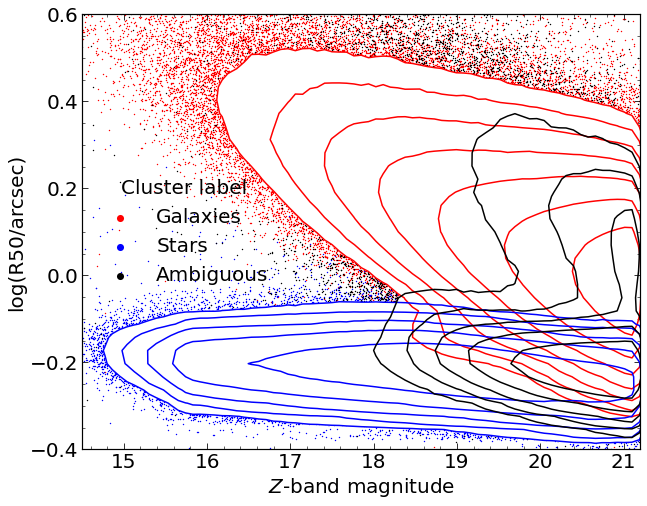

In [597]:
xlim=[14.5,21.2]
ylim=[-0.4,0.6]
log=[2.5,5,8]
smooth=0.5
plt.scatter(gals['mag_z_tot'][::10],np.log10(gals['R50'][::10]),s=2,linewidth=0,c='red',label='Galaxies')
plt.scatter(stars['mag_z_tot'][::10],np.log10(stars['R50'][::10]),s=2,linewidth=0,c='blue',label='Stars')
plt.scatter(amb['mag_z_tot'][::10],np.log10(amb['R50'][::10]),s=2,linewidth=0,c='k',label='Ambiguous')

z,x,y=np.histogram2d(gals['mag_z_tot'],
                     np.log10(gals['R50']), 
                     bins=(np.linspace(xlim[0]-1,xlim[1]+1,100),np.linspace(ylim[0]-1,ylim[1]+1,100)))
xcenters = (x[:-1] + x[1:]) / 2
ycenters = (y[:-1] + y[1:]) / 2
plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='red',
            levels=np.logspace(log[0],log[1],log[2]))
plt.contourf(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='w',
             levels=np.logspace(log[0],log[1],log[2]))

z,x,y=np.histogram2d(stars['mag_z_tot'],
                     np.log10(stars['R50']), 
                     bins=(np.linspace(xlim[0]-1,xlim[1]+1,100),np.linspace(ylim[0]-1,ylim[1]+1,100)))
xcenters = (x[:-1] + x[1:]) / 2
ycenters = (y[:-1] + y[1:]) / 2
plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='blue'
           ,levels=np.logspace(log[0],log[1],log[2]))
plt.contourf(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='w'
           ,levels=np.logspace(log[0],log[1],log[2]))

z,x,y=np.histogram2d(amb['mag_z_tot'],
                     np.log10(amb['R50']), 
                     bins=(np.linspace(xlim[0]-1,xlim[1]+1,100),np.linspace(ylim[0]-1,ylim[1]+1,100)))
xcenters = (x[:-1] + x[1:]) / 2
ycenters = (y[:-1] + y[1:]) / 2
plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='k'
           ,levels=np.logspace(log[0],log[1],log[2]))
plt.contourf(xcenters, ycenters, gaussian_filter(z.transpose(), smooth), colors='w'
           ,levels=np.logspace(log[0],log[1],log[2]))



plt.xlim(xlim[0],xlim[1])
plt.ylim(ylim[0],ylim[1])
plt.xlabel(r'$Z$'+'-band magnitude')
plt.ylabel('log(R50/arcsec)')

lgnd=plt.legend(frameon=False,loc='center left',title='Cluster label')

lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]

#plt.savefig('paper_plots/z_r50_cluster.jpg',bbox_inches='tight',dpi=500)

plt.show()

In [598]:
sample=sdss_matches[(sdss_matches['mag_z_tot']>20)]

(array([4603.,    0.,    0.,    0.,    0., 4549.,    0.,    0.,    0.,
        3840.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

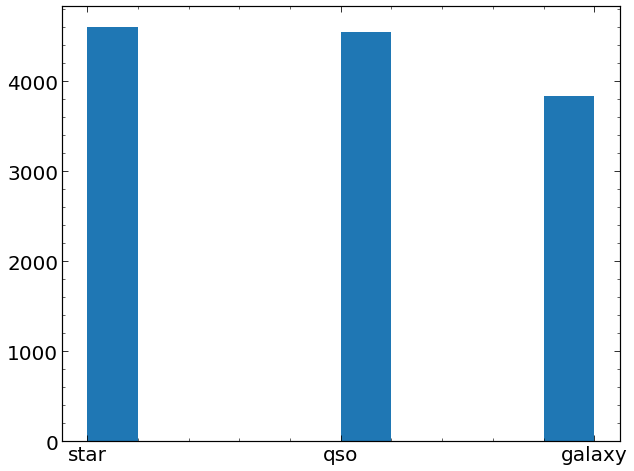

In [599]:
plt.hist(sample[sample['survey'] == 'boss  ']['spec_class'])

(array([107335.,      0.,      0.,      0.,      0.,  25950.,      0.,
             0.,      0.,  13372.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

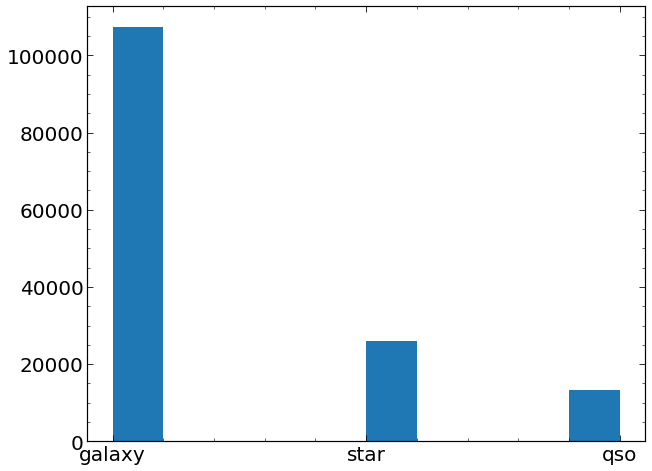

In [600]:
plt.hist(sdss_matches['spec_class'])

(array([12992.,     0.,     0.,   631.,     0.,     0.,   224.,     0.,
            0.,    49.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

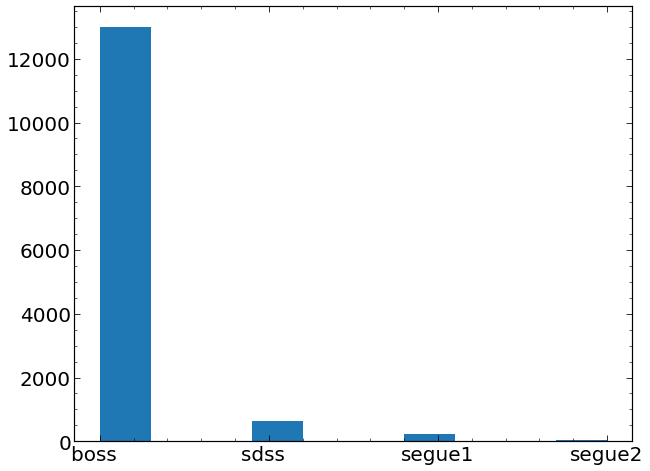

In [601]:
plt.hist(sample['survey'])

In [602]:
9919/(9919+461+202+40)

0.9338166070419883

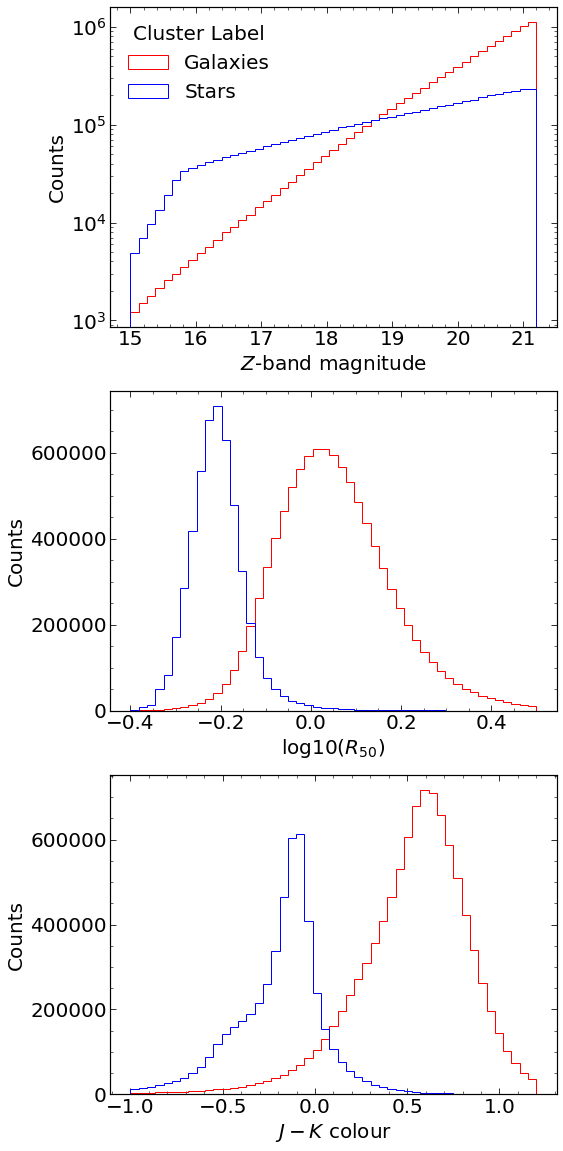

In [603]:
fig = plt.figure(figsize=(8,20))
spec = matplotlib.gridspec.GridSpec(ncols=1, nrows=3) # 6 columns evenly divides both 2 & 3
plt.subplots_adjust(hspace=0.2)
ax1 = fig.add_subplot(spec[0,0]) 
ax2 = fig.add_subplot(spec[1,0])
ax3 = fig.add_subplot(spec[2,0])

ax1.hist((df_nan[df_nan['cluster_label']=='galaxy']['mag_z_tot']),bins=np.linspace(15,21.2,50),
         histtype='step',color='red',label='Galaxies')
ax1.hist((df_nan[df_nan['cluster_label']=='star']['mag_z_tot']),bins=np.linspace(15,21.2,50),
         histtype='step',color='blue',label='Stars')
ax1.set_xlabel('$Z$'+'-band magnitude')
ax1.set_ylabel('Counts')
ax1.set_yscale('log')
ax1.legend(loc='upper left',frameon=False,title='Cluster Label')

ax2.hist(np.log10(df_nan[df_nan['cluster_label']=='galaxy']['R50']),bins=np.linspace(-0.4,0.5,50),
         histtype='step',color='red',label='Galaxies')
ax2.hist(np.log10(df_nan[df_nan['cluster_label']=='star']['R50']),bins=np.linspace(-0.4,0.5,50),
         histtype='step',color='blue',label='Stars')
ax2.set_xlabel('log10('+'$R_{50}$)')
ax2.set_ylabel('Counts')

ax3.hist((df_nan[df_nan['cluster_label']=='galaxy']['mag_j_tot'] - 
         df_nan[df_nan['cluster_label']=='galaxy']['mag_k_tot']),
         bins=np.linspace(-1,1.2,50),histtype='step',color='red')
ax3.hist((df_nan[df_nan['cluster_label']=='star']['mag_j_tot'] - 
         df_nan[df_nan['cluster_label']=='star']['mag_k_tot']),
         bins=np.linspace(-1,1.2,50),histtype='step',color='blue')
ax3.set_xlabel('$J-K$'+' colour')
ax3.set_ylabel('Counts')

#plt.savefig('paper_plots/properties.jpg',bbox_inches='tight',dpi=500)
plt.show()

In [604]:
from sklearn import metrics

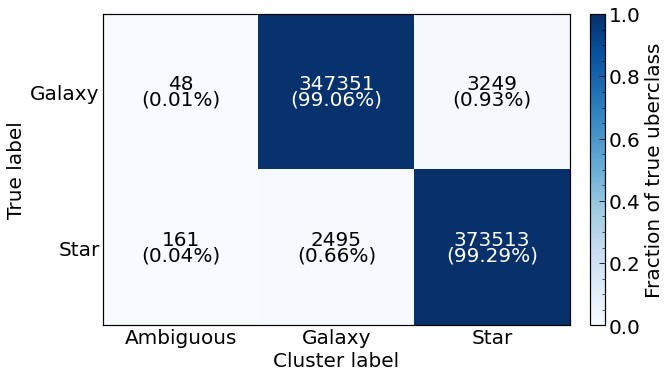

In [605]:
confusion_matrix = metrics.confusion_matrix(df_total['spec_class'], 
                                            df_total['cluster_label'])

fig, ax = plt.subplots(1,1,figsize=(9,7))
data=confusion_matrix[[1,2]]
data2=np.zeros([2,3])
data2[0,0] = data[0,0]/sum(data[0])*100
data2[0,1] = data[0,1]/sum(data[0])*100
data2[0,2] = data[0,2]/sum(data[0])*100
data2[1,0] = data[1,0]/sum(data[1])*100
data2[1,1] = data[1,1]/sum(data[1])*100
data2[1,2] = data[1,2]/sum(data[1])*100

im=ax.imshow(data2/100,vmin=0,vmax=1,cmap='Blues')

x_label_list = ['Ambiguous','Galaxy', 'Star']
y_label_list = ['Galaxy','Star']

for i in range(0, data.shape[1]):
    for j in range(0, data.shape[0]):
        c = data[j,i]
        if c < sum(data[j])/2:
            ax.text(i, j-0.05, str(c), va='center', ha='center',color='black')
        else:
            ax.text(i, j-0.05, str(c), va='center', ha='center',color='white')
            
for i in range(0, data2.shape[1]):
    for j in range(0, data2.shape[0]):
        c = round(data2[j,i],2)
        if c < sum(data2[j])/2:
            ax.text(i, j+0.05, '('+str(c)+'%)', va='center', ha='center',color='black')
        else:
            ax.text(i, j+0.05, '('+str(c)+ '%)', va='center', ha='center',color='white')
            
fig.colorbar(im,label='Fraction of true uberclass',fraction=0.031, pad=0.04)
        
plt.xticks([0,1,2], x_label_list)
plt.yticks([0,1], y_label_list)

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,
    left=False,
    right=False# ticks along the top edge are off
)

plt.xlabel('Cluster label')
plt.ylabel('True label')

plt.savefig('paper_plots/GAMA_WAVES_classifier_confusion_matrix_all.jpg',bbox_inches='tight',dpi=100,facecolor='white')

plt.show()

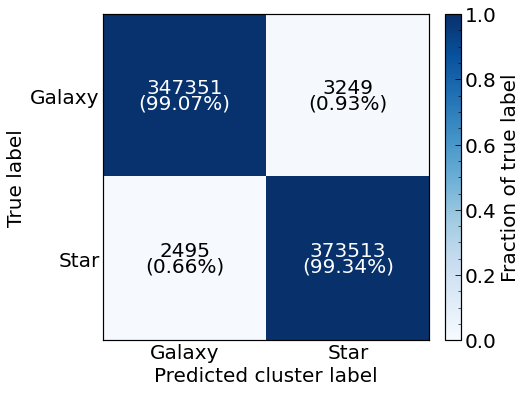

In [606]:
confusion_matrix = metrics.confusion_matrix(df_total['spec_class'], 
                                            df_total['cluster_label'])

fig, ax = plt.subplots(1,1,figsize=(7,6))
data=confusion_matrix[:,[1,2]][[1,2]]
data2=np.zeros([2,2])
data2[0,0] = data[0,0]/sum(data[0])*100
data2[0,1] = data[0,1]/sum(data[0])*100
data2[1,0] = data[1,0]/sum(data[1])*100
data2[1,1] = data[1,1]/sum(data[1])*100

im=ax.imshow(data2/100,vmin=0,vmax=1,cmap='Blues')

x_label_list = ['Galaxy', 'Star']
y_label_list = ['Galaxy','Star']

for i in range(0, data.shape[1]):
    for j in range(0, data.shape[0]):
        c = data[j,i]
        if c < sum(data[j])/2:
            ax.text(i, j-0.05, str(c), va='center', ha='center',color='black')
        else:
            ax.text(i, j-0.05, str(c), va='center', ha='center',color='white')
            
for i in range(0, data2.shape[1]):
    for j in range(0, data2.shape[0]):
        c = round(data2[j,i],2)
        if c < sum(data2[j])/2:
            ax.text(i, j+0.05, '('+str(c)+'%)', va='center', ha='center',color='black')
        else:
            ax.text(i, j+0.05, '('+str(c)+ '%)', va='center', ha='center',color='white')
            
fig.colorbar(im,label='Fraction of true label',fraction=0.045, pad=0.04)
        
plt.xticks([0,1], x_label_list)
plt.yticks([0,1], y_label_list)

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,
    left=False,
    right=False# ticks along the top edge are off
)

plt.xlabel('Predicted cluster label')
plt.ylabel('True label')

plt.savefig('paper_plots/cluster_confus.jpg',bbox_inches='tight',dpi=100,facecolor='white')

plt.show()

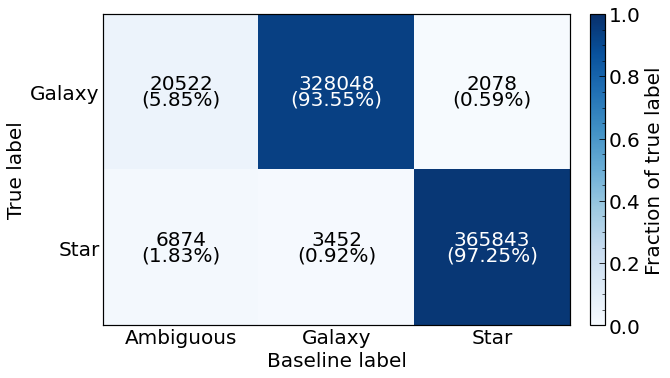

In [607]:
confusion_matrix = metrics.confusion_matrix(df_total['spec_class'], 
                                            df_total['class'])

fig, ax = plt.subplots(1,1,figsize=(9,7))
data=confusion_matrix[[1,2]]
data2=np.zeros([2,3])
data2[0,0] = data[0,0]/sum(data[0])*100
data2[0,1] = data[0,1]/sum(data[0])*100
data2[0,2] = data[0,2]/sum(data[0])*100
data2[1,0] = data[1,0]/sum(data[1])*100
data2[1,1] = data[1,1]/sum(data[1])*100
data2[1,2] = data[1,2]/sum(data[1])*100

im=ax.imshow(data2/100,vmin=0,vmax=1,cmap='Blues')

x_label_list = ['Ambiguous','Galaxy', 'Star']
y_label_list = ['Galaxy','Star']

for i in range(0, data.shape[1]):
    for j in range(0, data.shape[0]):
        c = data[j,i]
        if c < sum(data[j])/2:
            ax.text(i, j-0.05, str(c), va='center', ha='center',color='black')
        else:
            ax.text(i, j-0.05, str(c), va='center', ha='center',color='white')
            
for i in range(0, data2.shape[1]):
    for j in range(0, data2.shape[0]):
        c = round(data2[j,i],2)
        if c < sum(data2[j])/2:
            ax.text(i, j+0.05, '('+str(c)+'%)', va='center', ha='center',color='black')
        else:
            ax.text(i, j+0.05, '('+str(c)+ '%)', va='center', ha='center',color='white')
            
fig.colorbar(im,label='Fraction of true label',fraction=0.031, pad=0.04)
        
plt.xticks([0,1,2], x_label_list)
plt.yticks([0,1], y_label_list)

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,
    left=False,
    right=False# ticks along the top edge are off
)

plt.xlabel('Baseline label')
plt.ylabel('True label')


plt.savefig('paper_plots/baseline_confus.jpg',bbox_inches='tight',dpi=100,facecolor='white')

plt.show()

In [608]:
TP=len(df_total[(df_total['cluster_label']=='galaxy') & (df_total['spec_class']=='galaxy')])
FP=len(df_total[(df_total['cluster_label']=='galaxy') & (df_total['spec_class']=='star')])
FN=len(df_total[(df_total['cluster_label']=='star') & (df_total['spec_class']=='galaxy')])
P=TP/(TP+FP)
C=TP/(TP+FN)
F1=2*((P*C)/(P+C))
print(P,C,F1)

0.992868290619301 0.9907330290929834 0.9917995105975337


In [609]:
TP=len(df_total[((df_total['class']=='galaxy')|(df_total['class']=='ambiguous')) & (df_total['spec_class']=='galaxy')])
FP=len(df_total[((df_total['class']=='galaxy')|(df_total['class']=='ambiguous')) & (df_total['spec_class']=='star')])
FN=len(df_total[(df_total['class']=='star') & (df_total['spec_class']=='galaxy')])
P=TP/(TP+FP)
C=TP/(TP+FN)
F1=2*((P*C)/(P+C))
print(P,C,F1)

0.9712284338638492 0.9940738290251192 0.9825183498134014


In [610]:
len(df_total[(df_total['spec_class']=='galaxy') & 
             (df_total['cluster_label']=='galaxy')])/len(df_total[df_total['spec_class']=='galaxy'])

0.9905974082270539

In [611]:
(len(sdss_matches[sdss_matches['spec_class']=='galaxy'])/
 (len(sdss_matches[sdss_matches['spec_class']=='galaxy'])+len(sdss_matches[sdss_matches['spec_class']=='star'])))

0.8053044228532843

In [612]:
len(df_nan[(df_nan['missing_bands']==False) & ((df_nan['class']=='galaxy')|(df_nan['class']=='ambiguous'))])

11513554

In [613]:
gaia_matches

RAmax     Decmax       R50       R90      R100  \
uberID                                                                 
158000396800300  157.252695  -0.058357  0.682890  2.161739  7.165656   
158000038800872  157.551003  -0.010694  0.659507  2.180667  7.563799   
158000158900801  157.450931  -0.016610  0.644446  2.031458  6.310600   
158970137813867  158.868773  -1.927746  0.640464  2.186387  9.322436   
158970745701891  158.361910  -2.925783  0.595895  2.166361  9.495732   
...                     ...        ...       ...       ...       ...   
53650639107138    52.362072 -35.088526  0.609540  2.054481  4.959253   
53650529902193    52.474163 -35.500493  0.552153  1.851254  4.693750   
53650994702008    51.998345 -35.515659  0.575134  1.903348  4.667571   
53650664805359    52.335965 -35.236786  0.568720  2.092921  5.415622   
53651093602042    51.897111 -35.512531  0.622866  1.767222  4.175701   

                    axrat class cluster_label  missing_bands  mag_u_tot  \
uberID                                                                    
158000396800300  0.916681  star          star          False  21.255504   
158000038800872  0.956414  star          star          False  20.810802   
158000158900801  0.976183  star          star          False  21.617830   
158970137813867  0.939790  star          star          False  19.492074   
158970745701891  0.906437  star          star          False  18.322917   
...                   ...   ...           ...            ...        ...   
53650639107138   0.909727  star          star          False  22.358716   
53650529902193   0.963543  star          star          False  23.221578   
53650994702008   0.957287  star          star          False  23.685738   
53650664805359   0.885938  star          star          False  23.558934   
53651093602042   0.949646  star          star          False  20.645178   

                 mag_g_tot  mag_r_tot  mag_i_tot  mag_z_tot  mag_y_tot  \
uberID                                                                   
158000396800300  18.415185  17.096814  16.543669  16.258901  16.043277   
158000038800872  18.114385  17.011888  16.644526  16.467709  16.286253   
158000158900801  18.833187  17.513926  16.871815  16.540796  16.311609   
158970137813867  16.888370  15.860210  15.530660  15.389904  15.216559   
158970745701891  16.477924  15.780447  15.560983  15.496283  15.370212   
...                    ...        ...        ...        ...        ...   
53650639107138   20.183479  18.747658  17.861038  17.392666  17.125408   
53650529902193   20.295795  18.886705  17.810948  17.225745  16.902397   
53650994702008   20.616534  19.213641  18.075940  17.448311  17.129445   
53650664805359   20.477018  19.106884  17.899777  17.315972  16.959292   
53651093602042   19.476122  18.984311  18.818901  18.670568  18.640176   

                 mag_j_tot  mag_h_tot  mag_k_tot   flux_Zt  log10seeing  \
uberID                                                                    
158000396800300  16.000640  15.851042  16.128582  0.001139    -0.180627   
158000038800872  16.281894  16.170149  16.424421  0.000940    -0.180627   
158000158900801  16.241384  16.054758  16.314940  0.000878    -0.180627   
158970137813867  15.223898  15.062620  15.398855  0.002535    -0.169091   
158970745701891  15.441427  15.428068  15.761522  0.002299    -0.169091   
...                    ...        ...        ...       ...          ...   
53650639107138   17.039841  16.915757  17.152209  0.000401    -0.200229   
53650529902193   16.777239  16.691344  16.853182  0.000467    -0.200229   
53650994702008   17.009338  16.914104  17.147557  0.000381    -0.200229   
53650664805359   16.834093  16.712479  16.957594  0.000430    -0.200229   
53651093602042   18.905263  19.075131  19.283024  0.000124    -0.200229   

                        SB            source_id          ra        dec  \
uberID                                                                   
158000396800300  16.57

In [614]:
lower_mag_lim=16
upper_mag_lim=21.2

r_mag_bins=np.linspace(lower_mag_lim,upper_mag_lim,20)
r_bin_cens= (r_mag_bins[:-1] + r_mag_bins[1:]) / 2

In [615]:
rmag_tot_f1=[]
rmag_tot_f1_err=[]
rmag_tot_baseline_f1=[]
rmag_tot_baseline_f1_err=[]
rmag_tot_p=[]
rmag_tot_p_err=[]
rmag_tot_baseline_p=[]
rmag_tot_baseline_p_err=[]
rmag_tot_r=[]
rmag_tot_r_err=[]
rmag_tot_baseline_r=[]
rmag_tot_baseline_r_err=[]

rmag_waves_f1=[]
rmag_waves_baseline_f1=[]
rmag_waves_p=[]
rmag_waves_baseline_p=[]
rmag_waves_r=[]
rmag_waves_baseline_r=[]

rmag_desi_f1=[]
rmag_desi_baseline_f1=[]
rmag_desi_p=[]
rmag_desi_baseline_p=[]
rmag_desi_r=[]
rmag_desi_baseline_r=[]



for i in tqdm(range(len(r_mag_bins)-1)):
    r_low=r_mag_bins[i]
    r_high=r_mag_bins[i+1]
    

    lim=df_total[(df_total['mag_z_tot']>r_low) & (df_total['mag_z_tot']<r_high)]
    TP=len(lim[(lim['cluster_label']=='galaxy') & (lim['spec_class']=='galaxy')])
    FP=len(lim[(lim['cluster_label']=='galaxy') & (lim['spec_class']=='star')])
    FN=len(lim[(lim['cluster_label']=='star') & (lim['spec_class']=='galaxy')])
    P=TP/(TP+FP)
    R=TP/(TP+FN)
    F1=2*(P*R)/(P+R)
    rmag_tot_f1.append(F1)
    rmag_tot_p.append(P)
    rmag_tot_r.append(R)
    rmag_tot_p_err.append(P * np.sqrt(((FP/(TP+FP)**2)**2)*TP + ((TP/(TP+FP)**2)**2)*FP))
    rmag_tot_r_err.append(R * np.sqrt(((FN/(TP+FN)**2)**2)*TP + ((TP/(TP+FN)**2)**2)*FN))
    rmag_tot_f1_err.append(F1 * np.sqrt(((2*(FP+FN)/(2*TP+FP+FN)**2)**2)*TP + 
                                                 ((2*(TP)/(2*TP+FP+FN)**2)**2)*FP +
                                                 ((2*(TP)/(2*TP+FP+FN)**2)**2)*FN))
    
    TP=len(lim[((lim['class']=='galaxy')|(lim['class']=='ambiguous')) & (lim['spec_class']=='galaxy')])
    FP=len(lim[((lim['class']=='galaxy')|(lim['class']=='ambiguous')) & (lim['spec_class']=='star')])
    FN=len(lim[(lim['class']=='star') & (lim['spec_class']=='galaxy')])
    P=TP/(TP+FP)
    R=TP/(TP+FN)
    rmag_tot_baseline_f1.append(2*(P*R)/(P+R))
    rmag_tot_baseline_p.append(P)
    rmag_tot_baseline_r.append(R)
    rmag_tot_baseline_p_err.append(P * np.sqrt(((FP/(TP+FP)**2)**2)*TP + ((TP/(TP+FP)**2)**2)*FP))
    rmag_tot_baseline_r_err.append(R * np.sqrt(((FN/(TP+FN)**2)**2)*TP + ((TP/(TP+FN)**2)**2)*FN))
    rmag_tot_baseline_f1_err.append(F1 * np.sqrt(((2*(FP+FN)/(2*TP+FP+FN)**2)**2)*TP + 
                                                 ((2*(TP)/(2*TP+FP+FN)**2)**2)*FP +
                                                 ((2*(TP)/(2*TP+FP+FN)**2)**2)*FN))
    
    lim=waves_matches[(waves_matches['mag_z_tot']>r_low) & (waves_matches['mag_z_tot']<r_high)]
    TP=len(lim[(lim['cluster_label']=='galaxy') & (lim['spec_class']=='galaxy')])
    FP=len(lim[(lim['cluster_label']=='galaxy') & (lim['spec_class']=='star')])
    FN=len(lim[(lim['cluster_label']=='star') & (lim['spec_class']=='galaxy')])
    P=TP/(TP+FP)
    R=TP/(TP+FN)
    rmag_waves_f1.append(2*(P*R)/(P+R))
    rmag_waves_p.append(P)
    rmag_waves_r.append(R)
    
    TP=len(lim[((lim['class']=='galaxy')|(lim['class']=='ambiguous')) & (lim['spec_class']=='galaxy')])
    FP=len(lim[((lim['class']=='galaxy')|(lim['class']=='ambiguous')) & (lim['spec_class']=='star')])
    FN=len(lim[(lim['class']=='star') & (lim['spec_class']=='galaxy')])
    P=TP/(TP+FP)
    R=TP/(TP+FN)
    rmag_waves_baseline_f1.append(2*(P*R)/(P+R))
    rmag_waves_baseline_p.append(P)
    rmag_waves_baseline_r.append(R)
    
    lim=desi_matches[(desi_matches['mag_z_tot']>r_low) & (desi_matches['mag_z_tot']<r_high)]
    TP=len(lim[(lim['cluster_label']=='galaxy') & (lim['spec_class']=='galaxy')])
    FP=len(lim[(lim['cluster_label']=='galaxy') & (lim['spec_class']=='star')])
    FN=len(lim[(lim['cluster_label']=='star') & (lim['spec_class']=='galaxy')])
    P=TP/(TP+FP)
    R=TP/(TP+FN)
    rmag_desi_f1.append(2*(P*R)/(P+R))
    rmag_desi_p.append(P)
    rmag_desi_r.append(R)
    
    TP=len(lim[((lim['class']=='galaxy')|(lim['class']=='ambiguous')) & (lim['spec_class']=='galaxy')])
    FP=len(lim[((lim['class']=='galaxy')|(lim['class']=='ambiguous')) & (lim['spec_class']=='star')])
    FN=len(lim[(lim['class']=='star') & (lim['spec_class']=='galaxy')])
    P=TP/(TP+FP)
    R=TP/(TP+FN)
    rmag_desi_baseline_f1.append(2*(P*R)/(P+R))
    rmag_desi_baseline_p.append(P)
    rmag_desi_baseline_r.append(R)
    

    

  0%|          | 0/19 [00:00<?, ?it/s]

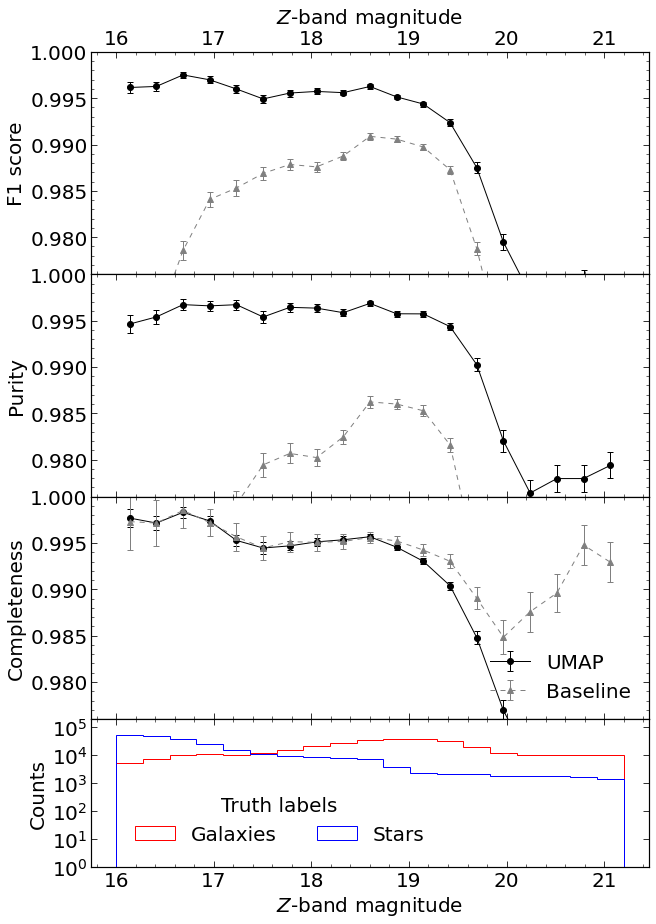

In [616]:
fig, axs = plt.subplots(4,sharex=True,gridspec_kw={'height_ratios': [3,3,3, 2]},figsize=(10,15))

axs[0].errorbar(r_bin_cens,rmag_tot_f1,yerr=rmag_tot_f1_err,
                c='k',linewidth=1,label='UMAP',capsize=3,marker='o')
axs[0].errorbar(r_bin_cens,rmag_tot_baseline_f1,yerr=rmag_tot_baseline_f1_err,
                linestyle=(0,(5,5)),c='grey',linewidth=1,label='Baseline',capsize=3,marker='^')
axs[0].set_ylim(0.976,1)
axs[0].tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
axs[0].set_title('$Z$'+'-band magnitude',fontsize=20)
axs[0].set_ylabel('F1 score')#,rotation=0,labelpad=50)
             

axs[1].errorbar(r_bin_cens,rmag_tot_p,yerr=rmag_tot_p_err,c='k',linewidth=1,capsize=3,marker='o')
axs[1].errorbar(r_bin_cens,rmag_tot_baseline_p,yerr=rmag_tot_baseline_p_err,
                linestyle=(0,(5,5)),linewidth=1,capsize=3,marker='^',c='grey')
axs[1].set_ylim(0.976,1)
axs[1].set_ylabel('Purity')


axs[2].errorbar(r_bin_cens,rmag_tot_r,yerr=rmag_tot_p_err,c='k',linewidth=1,label='UMAP',capsize=3,marker='o')
axs[2].errorbar(r_bin_cens,rmag_tot_baseline_r,yerr=rmag_tot_baseline_p_err,
                linestyle=(0,(5,5)),linewidth=1,label='Baseline',capsize=3,marker='^',c='grey')
axs[2].set_ylim(0.976,1)
axs[2].legend(loc='lower right',frameon=False)
axs[2].set_ylabel('Completeness')


axs[3].set_xlabel('$Z$'+'-band magnitude')
axs[3].hist(df_total[df_total['spec_class']=='galaxy']['mag_z_tot'],
            bins=r_mag_bins,histtype='step',color='red',label='Galaxies')
axs[3].hist(df_total[df_total['spec_class']=='star']['mag_z_tot'],
            bins=r_mag_bins,histtype='step',color='blue',label='Stars')
axs[3].set_ylim(1,200000)
axs[3].set_ylabel('Counts')
axs[3].set_yscale('log')
axs[3].set_yticks([1,1e1,1e2,1e3,1e4,1e5])
axs[3].legend(bbox_to_anchor=(0.63,0.6),frameon=False,title='Truth labels',ncol=2)



plt.subplots_adjust(hspace=0)

#plt.savefig('paper_plots/z_f1_p_r.jpg',bbox_inches='tight',dpi=150)


In [617]:
np.std(rmag_tot_f1)

0.008937346010701038

In [618]:
np.std(rmag_tot_p)

0.007576651510608168

In [619]:
np.std(rmag_tot_r)

0.010372302944316193

In [620]:
np.std(rmag_tot_baseline_f1)

0.010295150127524343

In [621]:
np.std(rmag_tot_baseline_p)

0.01878357491383992

In [622]:
np.std(rmag_tot_baseline_r)

0.0035066803322522425

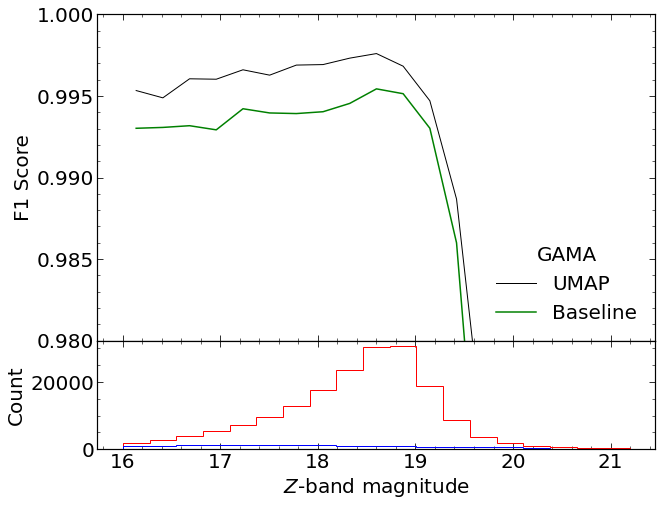

In [623]:
fig, axs = plt.subplots(2,sharex=True,gridspec_kw={'height_ratios': [3, 1]})
axs[0].plot(r_bin_cens,rmag_waves_f1,c='k',linewidth=1,markersize=10,label='UMAP')
axs[0].plot(r_bin_cens,rmag_waves_baseline_f1,c='green',label='Baseline',markersize=10)

axs[0].set_ylim(0.98,1)
axs[0].legend(loc='lower right',frameon=False,title='GAMA')
axs[0].set_ylabel('F1 Score')

axs[1].set_xlabel('$Z$'+'-band magnitude')
#axs[1].hist(waves_matches['mag_z_tot'],bins=r_mag_bins,histtype='step',color='k')
axs[1].hist(waves_matches[waves_matches['spec_class']=='galaxy']['mag_z_tot'],bins=r_mag_bins,histtype='step',color='red')
axs[1].hist(waves_matches[waves_matches['spec_class']=='star']['mag_z_tot'],bins=r_mag_bins,histtype='step',color='blue')

axs[1].set_ylabel('Count')


plt.subplots_adjust(hspace=0)

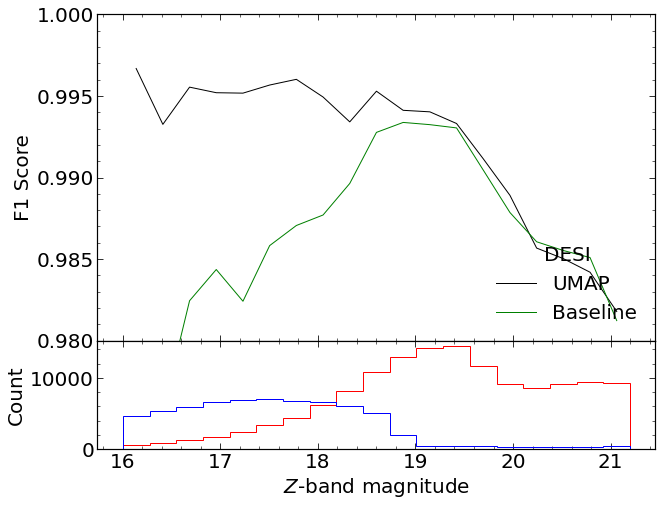

In [624]:
fig, axs = plt.subplots(2,sharex=True,gridspec_kw={'height_ratios': [3, 1]})
axs[0].plot(r_bin_cens,rmag_desi_f1,c='k',linewidth=1,markersize=10,label='UMAP')
axs[0].plot(r_bin_cens,rmag_desi_baseline_f1,c='green',linewidth=1,label='Baseline')
axs[0].set_ylim(0.98,1)
axs[0].legend(loc='lower right',frameon=False,title='DESI')
axs[0].set_ylabel('F1 Score')

axs[1].set_xlabel('$Z$'+'-band magnitude')
#axs[1].hist(desi_matches['mag_z_tot'],bins=r_mag_bins,histtype='step',color='k')
axs[1].hist(desi_matches[desi_matches['spec_class']=='galaxy']['mag_z_tot'],bins=r_mag_bins,histtype='step',color='red')
axs[1].hist(desi_matches[desi_matches['spec_class']=='star']['mag_z_tot'],bins=r_mag_bins,histtype='step',color='blue')


axs[1].set_ylabel('Count')

plt.subplots_adjust(hspace=0)

In [625]:
n_obs_class=len(df_nan[(df_nan['class']=='galaxy') | (df_nan['class']=='ambiguous')])
n_obs_cluster=len(df_nan[(df_nan['cluster_label']=='galaxy') | (df_nan['cluster_label']=='ambiguous')])

In [626]:
(n_obs_class-n_obs_cluster)/n_obs_class

0.14355153949761706

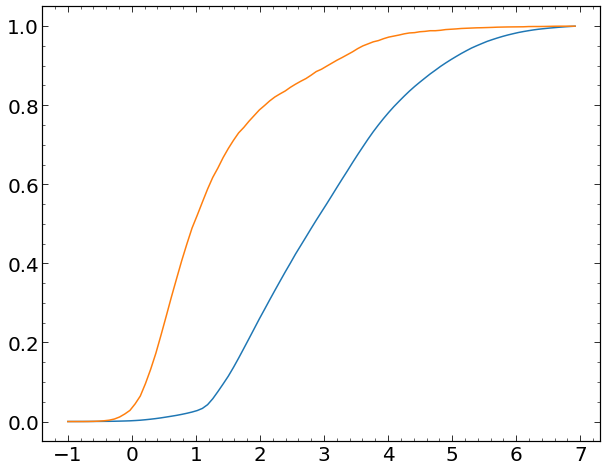

In [627]:
values, base = np.histogram(desi_matches['mag_u_tot']-desi_matches['mag_z_tot'], bins=np.linspace(-1,7,100))
cumulative = np.cumsum(values)/ np.cumsum(values)[-1]
plt.plot(base[:-1], cumulative)


values, base = np.histogram(desi_matches[desi_matches['spec_class']=='qso']['mag_u_tot'] - 
                            desi_matches[desi_matches['spec_class']=='qso']['mag_z_tot'], 
                            bins=np.linspace(-1,7,100))
cumulative = np.cumsum(values)/ np.cumsum(values)[-1]
plt.plot(base[:-1], cumulative)

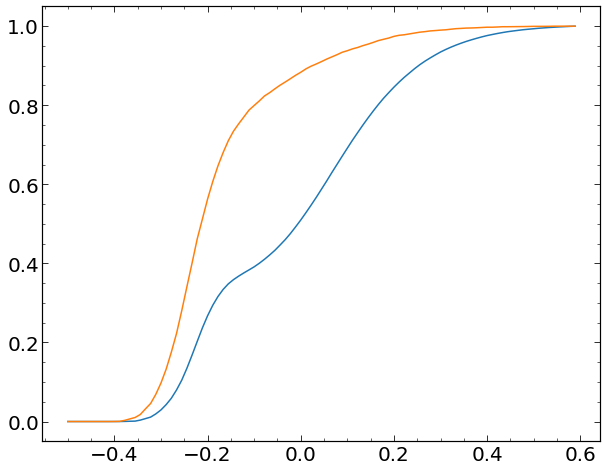

In [628]:
values, base = np.histogram(np.log10(desi_matches['R50']), bins=np.linspace(-0.5,0.6,100))
cumulative = np.cumsum(values)/ np.cumsum(values)[-1]
plt.plot(base[:-1], cumulative)


values, base = np.histogram(np.log10(desi_matches[desi_matches['spec_class']=='qso']['R50']), 
                            bins=np.linspace(-0.5,0.6,100))
cumulative = np.cumsum(values)/ np.cumsum(values)[-1]
plt.plot(base[:-1], cumulative)

In [630]:
qso=desi_matches[(desi_matches['spec_class']=='qso') & (desi_matches['morph']=='PSF')]
len(qso)

5929

In [646]:
np.median(qso['Z'])

1.6105886133367422

In [638]:
len(qso[qso['cluster_label']=='star'])

431

In [639]:
len(qso[qso['cluster_label']=='star'])/len(qso)

0.07269354022600776

In [644]:
len(qso[qso['class']=='ambiguous'])

3782

In [645]:
len(qso[qso['class']=='ambiguous'])/len(qso)

0.63788159892056

In [277]:
len(df_nan[(df_nan['mag_z_tot']>20) & (df_nan['cluster_label']=='star')])/len(df_nan[df_nan['mag_z_tot']>20])

0.21821565387570505

In [278]:
qso

KeyError: 'mask'

In [279]:
hdul = fits.open('../photoz-sfm.fits')
data = hdul[1].data
cols = hdul[1].columns
t=Table(data)
names = [name for name in t.colnames if len(t[name].shape) <= 1]
df_sfm=t[names].to_pandas()
del hdul
del data
del cols
del t

In [ ]:
df_sfm=df_sfm.set_index('ID')

In [ ]:
df_sfm.columns

In [ ]:
df_sfm = df_sfm.rename(columns={'Z': 'z_photo'})

In [ ]:
sfm_cols=['COUNT_CHISQ10','COUNT_CHISQ20', 'COUNT_CHISQ30', 'COUNT_EFF', 'ZETA', 'SD', 'ERR', 'z_photo']

In [ ]:
intersect=np.intersect1d(df_nan.index,df_sfm.index)

In [ ]:
for col in tqdm(sfm_cols):
    df_nan[col]=np.nan
    df_nan.loc[intersect,col]=df_sfm.loc[intersect][col]

In [ ]:
del df_sfm

In [ ]:
ivan=df_nan[((df_nan['COUNT_CHISQ30']>=100) | ((df_nan['COUNT_CHISQ30']>=10) & (df_nan['class']=='galaxy')))]

In [ ]:
df_nan['ivan']='star'

In [ ]:
df_nan.loc[df_nan[((df_nan['COUNT_CHISQ30']>=100) | 
                   ((df_nan['COUNT_CHISQ30']>=10) & (df_nan['class']=='galaxy')))].index,
          'ivan'] = 'galaxy'

In [ ]:
print('% of spurious stars with a good photo-z')
print(round(len(ivan[ivan['cluster_label']=='star'])/len(ivan),4)*100)

In [ ]:
print('% of galaxies without a good photo-z')
print(round(1-(len(np.intersect1d(df_nan[df_nan['cluster_label']=='galaxy'].index,ivan.index))/
            len(df_nan[df_nan['cluster_label']=='galaxy'])),4)*100)

In [ ]:
len(df_nan[(df_nan['cluster_label']=='galaxy') & (df_nan['z_photo']<0.2)])

In [ ]:
len(df_nan[(df_nan['cluster_label']=='galaxy') & (df_nan['z_photo']<0.2) 
           & (df_nan['COUNT_CHISQ30']>=100)])

In [ ]:
len(df_nan[((df_nan['class']=='galaxy')|(df_nan['class']=='ambiguous')) & (df_nan['z_photo']<0.2) 
           & (df_nan['COUNT_CHISQ30']>=100)])

In [ ]:
1286013-1223542

In [ ]:
plt.hist(df_nan[(df_nan['cluster_label']=='galaxy') & (df_nan['z_photo']<0.2)]['COUNT_CHISQ30'],
        bins=np.linspace(0,200,20))
plt.show()

In [ ]:
#probs=ivan[(ivan['cluster_label']=='star') & (ivan['Z']<0.2)]
probs=df_nan[(df_nan['cluster_label']=='star') & ((df_nan['class']=='galaxy')|(df_nan['class']=='ambiguous'))]

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(probs[probs['Decmax']>-20]['RAmax'],probs[probs['Decmax']>-20]['Decmax'],s=0.01,marker='o',linewidth=0)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlim(157.25,225)
plt.ylim(-4,4)
#plt.savefig('probs.jpg',bbox_inches='tight',dpi=500)
plt.show()

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(probs[probs['Decmax']<-20]['RAmax'],probs[probs['Decmax']<-20]['Decmax'],s=0.01,marker='o',linewidth=0)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlim(-30,52.5)
plt.ylim(-35.6,-27)
plt.savefig('probs.jpg',bbox_inches='tight',dpi=500)
plt.show()

In [ ]:
ids=np.intersect1d(df_speccat.index,df_nan.index)

In [ ]:
plt.scatter(df_speccat.loc[ids]['Z'],df_nan.loc[ids]['z_photo'],s=0.1,linewidth=0)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1],c='k')

In [ ]:
len(df_nan[(df_nan['mag_z_tot']>20) & (df_nan['cluster_label']=='star')])/len(df_nan[df_nan['mag_z_tot']>20])

In [ ]:
dec_bins=np.linspace(-4,4,100)
dec_cens=(dec_bins[:-1] + dec_bins[1:]) / 2
seeing=[]
for i in tqdm(range(len(dec_bins)-1)):
    dec_low=dec_bins[i]
    dec_high=dec_bins[i+1]
    seeing.append(np.median(df_nan[(df_nan['Decmax']>dec_low) & (df_nan['Decmax']<dec_high)]['log10seeing']))

In [ ]:
plt.hist(probs['Decmax'],bins=np.linspace(-4,4,100),histtype='step',density=True,color='k')
plt.hist(df_nan[df_nan['cluster_label']=='star']['Decmax'],bins=np.linspace(-4,4,100),histtype='step',density=True,color='blue')
plt.hist(df_nan[((df_nan['class']=='galaxy')|(df_nan['class']=='ambiguous'))]['Decmax'],bins=np.linspace(-4,4,100),histtype='step',density=True,color='red')
plt.ylim(0.08,0.16)
plt.show()

In [ ]:
plt.hist(probs['Decmax'],bins=np.linspace(-4,4,100),histtype='step',density=True,color='k')
plt.hist(df_nan[((df_nan['class']=='ambiguous')&(df_nan['cluster_label']=='star'))]['Decmax'],bins=np.linspace(-4,4,100),histtype='step',density=True,color='red')
plt.ylim(0.08,0.16)
plt.show()

In [ ]:
plt.hist(df_nan[((df_nan['cluster_label']=='galaxy')&(df_nan['class']=='galaxy'))]['Decmax'],
         bins=np.linspace(-4,4,100),histtype='step',density=True,color='red',label='galaxy')
plt.hist(df_nan[((df_nan['cluster_label']=='galaxy')&(df_nan['class']=='star'))]['Decmax'],
         bins=np.linspace(-4,4,100),histtype='step',density=True,color='blue',label='star')
plt.hist(df_nan[((df_nan['cluster_label']=='galaxy')&(df_nan['class']=='ambiguous'))]['Decmax'],
         bins=np.linspace(-4,4,100),histtype='step',density=True,color='k',label='amb')
plt.title('cluster label == galaxy')
for i in range(-4,5):
    plt.axvline(i,c='k',linewidth=1,alpha=0.5)
plt.legend()
plt.show()

In [ ]:
plt.hist(df_nan[((df_nan['cluster_label']=='star')&(df_nan['class']=='galaxy'))]['Decmax'],
         bins=np.linspace(-4,4,100),histtype='step',density=True,color='red',label='galaxy')
plt.hist(df_nan[((df_nan['cluster_label']=='star')&(df_nan['class']=='star'))]['Decmax'],
         bins=np.linspace(-4,4,100),histtype='step',density=True,color='blue',label='star')
plt.hist(df_nan[((df_nan['cluster_label']=='star')&(df_nan['class']=='ambiguous'))]['Decmax'],
         bins=np.linspace(-4,4,100),histtype='step',density=True,color='k',label='amb')
plt.title('cluster label == stars')
plt.legend()
for i in range(-4,5):
    plt.axvline(i,c='k',linewidth=1,alpha=0.5)
plt.show()

In [ ]:
plt.hist2d(df_nan['ymax'],df_nan['skyRMS_mean'],bins=[1000,1000],range=[[0,14000],[0.2e-11,0.6e-11]])
plt.show()

In [ ]:
plt.hist(probs['Decmax'],bins=np.linspace(-4,4,100),histtype='step',density=True)
plt.hist(df_nan[df_nan['cluster_label']=='star']['Decmax'],bins=np.linspace(-4,4,100),histtype='step',density=True)
plt.show()

In [ ]:
confusion_matrix = metrics.confusion_matrix(df_nan['ivan'], 
                                            df_nan['cluster_label'])

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(9,7))
data=confusion_matrix[[1,2]]
data2=np.zeros([2,3])
data2[0,0] = data[0,0]/sum(data[0])*100
data2[0,1] = data[0,1]/sum(data[0])*100
data2[0,2] = data[0,2]/sum(data[0])*100
data2[1,0] = data[1,0]/sum(data[1])*100
data2[1,1] = data[1,1]/sum(data[1])*100
data2[1,2] = data[1,2]/sum(data[1])*100

im=ax.imshow(data2/100,vmin=0,vmax=1,cmap='Blues')

x_label_list = ['Ambiguous','Galaxy', 'Star']
y_label_list = ['Galaxy','Star']

for i in range(0, data.shape[1]):
    for j in range(0, data.shape[0]):
        c = data[j,i]
        if c < sum(data[j])/2:
            ax.text(i, j-0.05, str(c), va='center', ha='center',color='black')
        else:
            ax.text(i, j-0.05, str(c), va='center', ha='center',color='white')
            
for i in range(0, data2.shape[1]):
    for j in range(0, data2.shape[0]):
        c = round(data2[j,i],2)
        if c < sum(data2[j])/2:
            ax.text(i, j+0.05, '('+str(c)+'%)', va='center', ha='center',color='black')
        else:
            ax.text(i, j+0.05, '('+str(c)+ '%)', va='center', ha='center',color='white')
            
fig.colorbar(im,label='Fraction of Ivan class',fraction=0.031, pad=0.04)
        
plt.xticks([0,1,2], x_label_list)
plt.yticks([0,1], y_label_list)

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,
    left=False,
    right=False# ticks along the top edge are off
)

plt.xlabel('Cluster label')
plt.ylabel('Ivan label')

#plt.savefig('plots/GAMA_WAVES_classifier_confusion_matrix_all.jpg',bbox_inches='tight',dpi=200,facecolor='white')

plt.show()

In [ ]:
plt.figure(figsize=(20,20))
plt.scatter(df_nan[(df_nan['Decmax']>-20) & (df_nan['cluster_label']=='galaxy') & 
                   (df_nan['z_photo']>0.1) & (df_nan['z_photo']<0.12)]['RAmax'],
            df_nan[(df_nan['Decmax']>-20) & (df_nan['cluster_label']=='galaxy') & 
                   (df_nan['z_photo']>0.1) & (df_nan['z_photo']<0.12)]['Decmax'],
            s=5,marker='o',linewidth=0)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlim(210,225)
plt.show()

In [ ]:
plt.hist(df_nan['skyRMS_mean'],bins=np.linspace(0.2e-11,0.6e-11,200),density=True,histtype='step')
plt.hist(probs['skyRMS_mean'],bins=np.linspace(0.2e-11,0.6e-11,200),density=True,histtype='step')
plt.show()

In [ ]:
dens=[]
rms=[]

dens_tot=[]
rms_tot=[]

dens_stars=[]
dens_gals=[]

stars=df_nan[df_nan['class']=='star']
gals=df_nan[df_nan['cluster_label']=='galaxy']


for frame in tqdm(np.unique(df_nan['FrameID'])):
    smol=probs[probs['FrameID']==frame]
    dens.append(len(smol)/len(probs))
    rms.append(np.median(smol['skyRMS_mean']))
    del smol
    
    smol_tot=df_nan[df_nan['FrameID']==frame]
    dens_tot.append(len(smol_tot)/len(df_nan))
    rms_tot.append(np.median(smol_tot['skyRMS_mean']))
    del smol_tot
    
    smol_stars=stars[stars['FrameID']==frame]
    dens_stars.append(len(smol_stars)/len(stars))
    del smol_stars
    
    smol_gals=gals[gals['FrameID']==frame]
    dens_gals.append(len(smol_gals)/len(gals))
    del smol_gals
    
    
del stars
del gals

In [ ]:
plt.scatter(rms_tot,dens_tot)
plt.scatter(rms,dens)

In [ ]:
z,x,y=np.histogram2d(rms,dens, bins=(np.linspace(2.5e-12,5e-12,20),np.linspace(0,0.0025,20)))
xcenters = (x[:-1] + x[1:]) / 2
ycenters = (y[:-1] + y[1:]) / 2
plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), 1), colors='red'
           ,levels=np.logspace(0,3,15),alpha=0.5)

z,x,y=np.histogram2d(rms_tot,dens_tot, bins=(np.linspace(2.5e-12,5e-12,20),np.linspace(0,0.0025,20)))
xcenters = (x[:-1] + x[1:]) / 2
ycenters = (y[:-1] + y[1:]) / 2
plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), 1), colors='blue'
           ,levels=np.logspace(0,3,15),alpha=0.5)
plt.xlabel('Average Frame skyRMS_mean')
plt.ylabel('Average Frame Density')

In [ ]:
#plt.scatter(dens_tot,dens,s=1)
plt.scatter(dens_tot,dens_stars,s=1)
plt.plot([0,0.002],[0,0.002],c='k')

In [339]:
waves_matches['ang_dist']=cosmo.angular_diameter_distance(waves_matches['Z']).values.value

/tmp/ipykernel_64430/827999989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waves_matches['ang_dist']=cosmo.angular_diameter_distance(waves_matches['Z']).values.value


In [340]:
waves_matches['re']=waves_matches['ang_dist']*waves_matches['R50']*np.pi/(180 * 3600)*1000

/tmp/ipykernel_64430/866933102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waves_matches['re']=waves_matches['ang_dist']*waves_matches['R50']*np.pi/(180 * 3600)*1000


In [341]:
waves_matches['sig']=np.log10(waves_matches['mstar']) - 1.5*np.log10(waves_matches['re'])

/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_64430/2062301064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waves_matches['sig']=np.log10(waves_matches['mstar']) - 1.5*np.log10(waves_matches['re'])


(-0.5, 1.5)

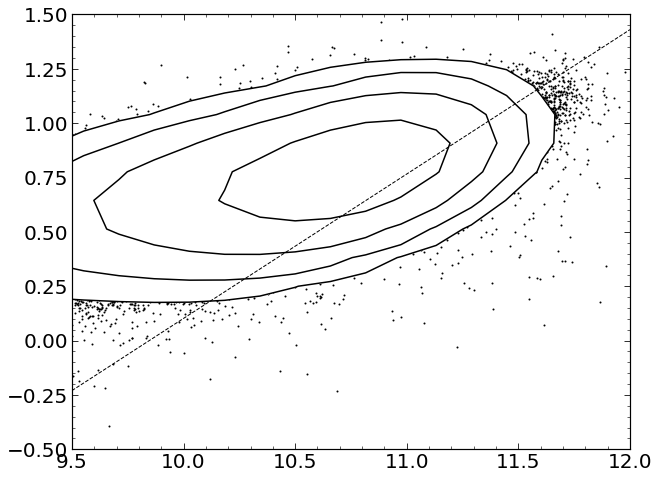

In [342]:
z,x,y=np.histogram2d(np.log10(waves_matches[(waves_matches['spec_class']=='galaxy') & (waves_matches['Z']<0.6)]['mstar']),
                     np.log10(waves_matches[(waves_matches['spec_class']=='galaxy') & (waves_matches['Z']<0.6)]['re']),
                     bins=(np.linspace(9,12,20),np.linspace(-1,1.5,20)))
xcenters = (x[:-1] + x[1:]) / 2
ycenters = (y[:-1] + y[1:]) / 2

plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), 1.1), colors='k', 
           levels=np.logspace(2.5,3.8,5),zorder=3)
plt.contourf(xcenters, ycenters, gaussian_filter(z.transpose(), 1.1),
           levels=np.logspace(2.5,3.8,5),zorder=2,colors='w')
plt.scatter(np.log10(waves_matches[(waves_matches['spec_class']=='galaxy') & (waves_matches['Z']<0.6)]['mstar']),
            np.log10(waves_matches[(waves_matches['spec_class']=='galaxy') & (waves_matches['Z']<0.6)]['re']),
            s=1,c='k')
plt.plot([9.5,12],[-0.23,1.43],c='k',linewidth=1,linestyle='dashed')
plt.xlim(9.5,12)
plt.ylim(-0.5,1.5)

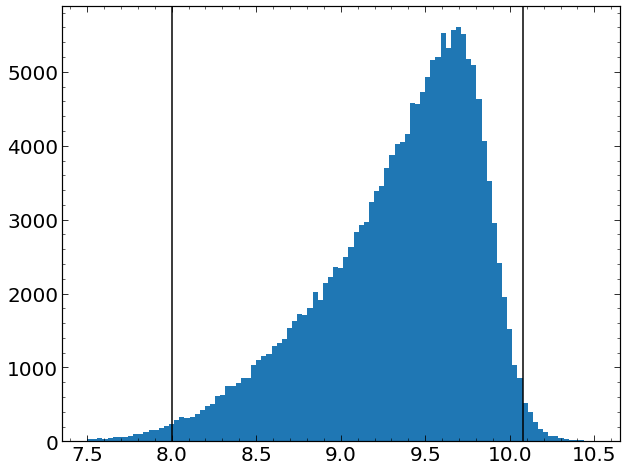

In [343]:
plt.hist(waves_matches[(waves_matches['Z']<0.6) & (waves_matches['spec_class']=='galaxy')]['sig'],
        bins=np.linspace(7.5,10.5,100))
plt.axvline(np.percentile(waves_matches[(waves_matches['Z']<0.6) & (waves_matches['spec_class']=='galaxy')
                           & (waves_matches['sig']>0)]['sig'],99),c='k')
plt.axvline(np.percentile(waves_matches[(waves_matches['Z']<0.6) & (waves_matches['spec_class']=='galaxy')
                           & (waves_matches['sig']>0)]['sig'],1),c='k')
plt.show()

In [344]:
sig_upper=np.percentile(waves_matches[(waves_matches['Z']<0.6) & (waves_matches['spec_class']=='galaxy')
                           & (waves_matches['sig']>0)]['sig'],99.5)
sig_lower=np.percentile(waves_matches[(waves_matches['Z']<0.6) & (waves_matches['spec_class']=='galaxy')
                           & (waves_matches['sig']>0)]['sig'],0.5)

In [345]:
compact=waves_matches[(waves_matches['Z']<0.6) & (waves_matches['spec_class']=='galaxy') & 
                      (waves_matches['sig']>sig_upper)]

(-0.5, 1.5)

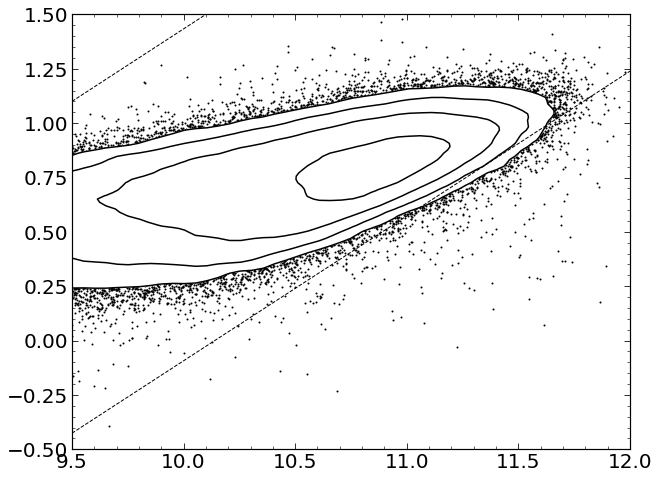

In [346]:
z,x,y=np.histogram2d(np.log10(waves_matches[(waves_matches['spec_class']=='galaxy') & (waves_matches['Z']<0.6)]['mstar']),
                     np.log10(waves_matches[(waves_matches['spec_class']=='galaxy') & (waves_matches['Z']<0.6)]['re']),
                     bins=(np.linspace(4,14,200),np.linspace(-1,2,200)))
xcenters = (x[:-1] + x[1:]) / 2
ycenters = (y[:-1] + y[1:]) / 2

plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), 1), colors='k', 
           levels=np.logspace(1,5,10),zorder=3)
plt.contourf(xcenters, ycenters, gaussian_filter(z.transpose(), 1),
           levels=np.logspace(1,5,10),zorder=2,colors='w')
plt.scatter(np.log10(waves_matches[(waves_matches['spec_class']=='galaxy') & (waves_matches['Z']<0.6)]['mstar']),
            np.log10(waves_matches[(waves_matches['spec_class']=='galaxy') & (waves_matches['Z']<0.6)]['re']),
            s=1,c='k')
plt.plot([9.5,12],[-0.426,1.239],c='k',linewidth=1,linestyle='dashed')
plt.plot([9.5,12],[1.100,2.767],c='k',linewidth=1,linestyle='dashed')
plt.xlim(9.5,12)
plt.ylim(-0.5,1.5)

(-0.5, 1.5)

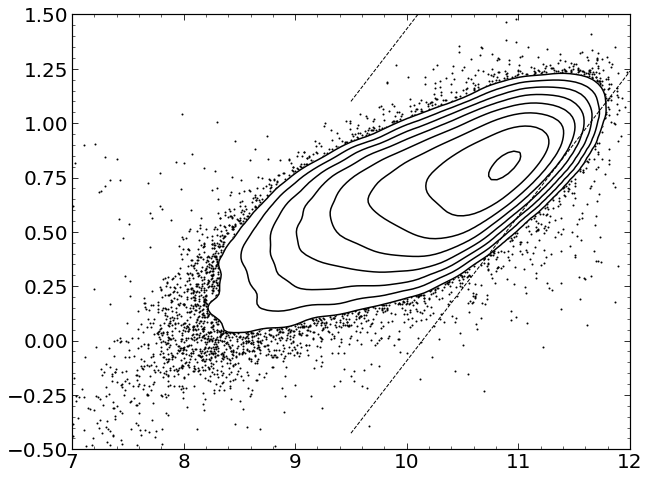

In [347]:
z,x,y=np.histogram2d(np.log10(waves_matches[(waves_matches['spec_class']=='galaxy') & (waves_matches['Z']<0.6)]['mstar']),
                     np.log10(waves_matches[(waves_matches['spec_class']=='galaxy') & (waves_matches['Z']<0.6)]['re']),
                     bins=(np.linspace(4,14,200),np.linspace(-1,2,200)))
xcenters = (x[:-1] + x[1:]) / 2
ycenters = (y[:-1] + y[1:]) / 2

plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), 2), colors='k', 
           levels=np.logspace(0.5,3,10),zorder=3)
plt.contourf(xcenters, ycenters, gaussian_filter(z.transpose(), 2),
           levels=np.logspace(0.5,3,10),zorder=2,colors='w')
plt.scatter(np.log10(waves_matches[(waves_matches['spec_class']=='galaxy') & (waves_matches['Z']<0.6)]['mstar']),
            np.log10(waves_matches[(waves_matches['spec_class']=='galaxy') & (waves_matches['Z']<0.6)]['re']),
            s=1,c='k')
plt.plot([9.5,12],[-0.426,1.239],c='k',linewidth=1,linestyle='dashed')
plt.plot([9.5,12],[1.100,2.767],c='k',linewidth=1,linestyle='dashed')
plt.xlim(7,12)
plt.ylim(-0.5,1.5)

In [348]:
df_total['SB']=8.9-2.5*np.log10(df_total['flux_Zt']/(np.pi*df_total['R50']**2 * df_total['axrat']))

In [349]:
sample=df_total[(df_total['spec_class']=='galaxy') & (df_total['SB']>0) & (df_total['Z']<0.2)]

In [350]:
sb_upper=np.percentile(sample['SB'],99.5)

In [351]:
sb_upper

22.654129951162126

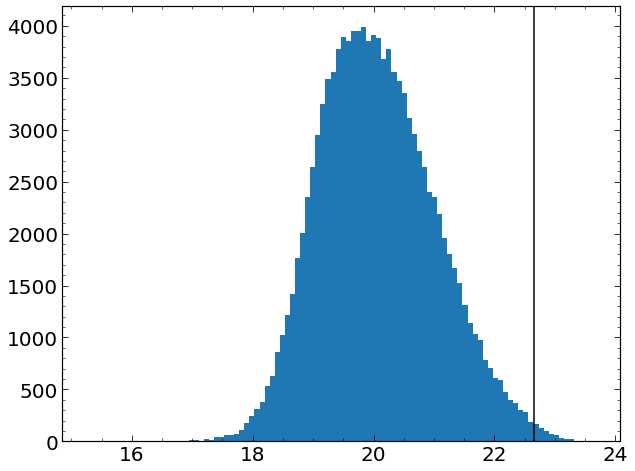

In [352]:
plt.hist(sample['SB'],bins=100)
plt.axvline(sb_upper,c='k')
plt.show()

In [353]:
diffuse=sample[sample['SB']>sb_upper]

In [354]:
np.mean(diffuse['SB'])

22.874354477819498

In [355]:
np.mean(sample['SB'])

20.070713133580163

(array([345.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 242.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

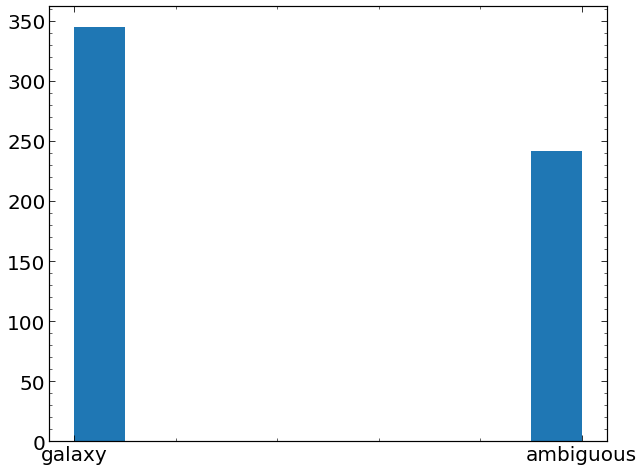

In [356]:
plt.hist(diffuse['class'])

In [357]:
def bar_chart(dataframe,columns,labels,title):
    values=[]
    for column in columns:
        values.append(list(dataframe[column].values))
    unique=np.unique(values)
    N=len(unique)
    
    ind=np.arange(N)
    width=0.3
    
    for i in range(len(columns)):
        column=columns[i]
        label=labels[i]
        bar=[]
        for LABEL in unique:
            bar.append(len(dataframe[dataframe[column]==LABEL]))
        plt.bar(ind + (i)*width,bar,width,label=label,linewidth=2,edgecolor='k')
    plt.xticks(ind + width / 2, unique)
    plt.title(title)
    plt.legend(frameon=False)
    plt.show()           

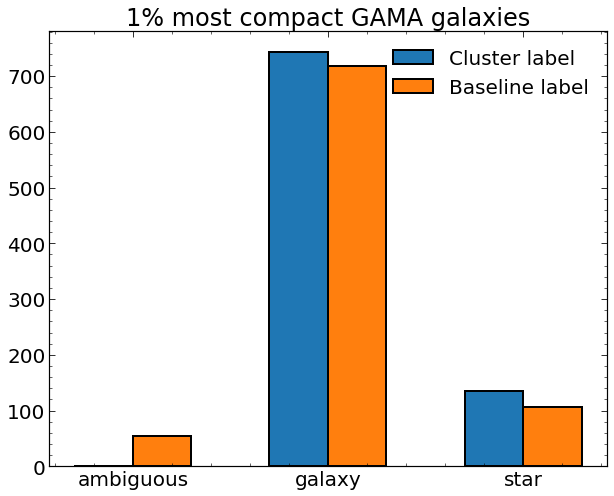

In [358]:
bar_chart(compact,['cluster_label','class'],['Cluster label','Baseline label'],
          '1% most compact GAMA galaxies')

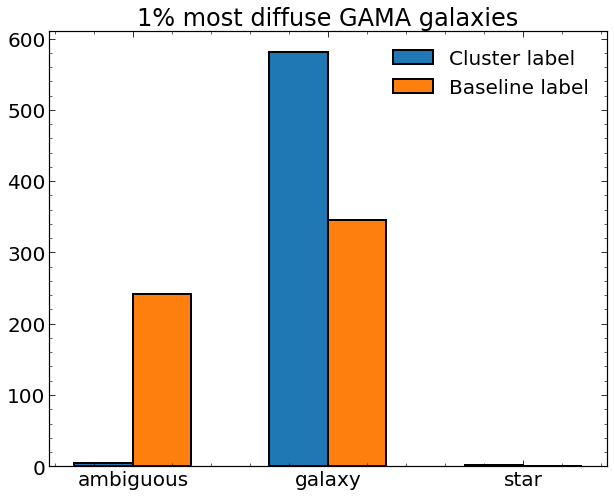

In [359]:
bar_chart(diffuse,['cluster_label','class'],['Cluster label','Baseline label'],
          '1% most diffuse GAMA galaxies')

In [407]:
len(diffuse)

583

In [408]:
len(diffuse[diffuse['cluster_label']=='galaxy'])/len(diffuse)

0.9965694682675815

In [417]:
sample=df_total[(df_total['spec_class']=='galaxy') & (df_total['Z']<0.8)]

In [419]:
len(sample[sample['class']=='galaxy'])/len(sample)

0.9484886969773939

In [406]:
diffuse=diffuse[diffuse['cluster_label']!='ambiguous']

In [303]:
print(len(diffuse[diffuse['class']=='galaxy']))
print(len(diffuse[diffuse['class']=='galaxy'])/len(diffuse))

345
0.5917667238421955


In [304]:
print(len(diffuse[diffuse['class']=='star']))
print(len(diffuse[diffuse['class']=='star'])/len(diffuse))

0
0.0


In [305]:
print(len(diffuse[diffuse['class']=='ambiguous']))
print(len(diffuse[diffuse['class']=='ambiguous'])/len(diffuse))

238
0.40823327615780447


(array([3.64658415e-04, 4.05176017e-04, 8.50869636e-04, 1.33708086e-03,
        2.14743289e-03, 3.97072497e-03, 9.11646038e-03, 3.07933773e-02,
        1.39177962e-01, 8.06745967e-01, 2.54276313e+00, 1.10373999e+00,
        9.89439833e-02, 7.86041473e-03, 1.29656325e-03, 2.43105610e-04,
        1.62070407e-04, 0.00000000e+00, 8.10352034e-05]),
 array([-2.        , -1.78947368, -1.57894737, -1.36842105, -1.15789474,
        -0.94736842, -0.73684211, -0.52631579, -0.31578947, -0.10526316,
         0.10526316,  0.31578947,  0.52631579,  0.73684211,  0.94736842,
         1.15789474,  1.36842105,  1.57894737,  1.78947368,  2.        ]),
 [<matplotlib.patches.Polygon at 0x2ba1f428ff40>])

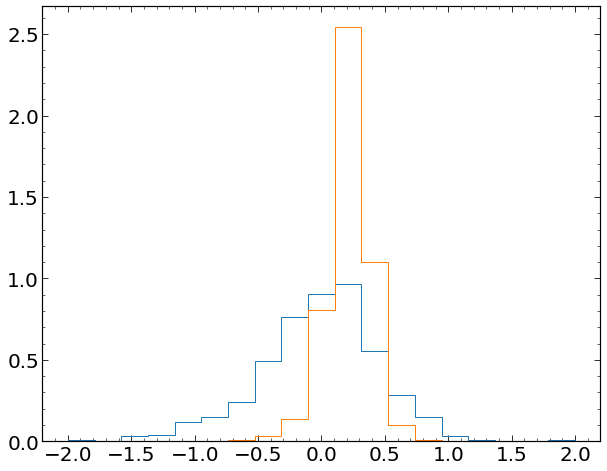

In [306]:
plt.hist(diffuse['mag_j_tot']-diffuse['mag_k_tot'],bins=np.linspace(-2,2,20),density=True,histtype='step')
plt.hist(sample['mag_j_tot']-sample['mag_k_tot'],bins=np.linspace(-2,2,20),density=True,histtype='step')

In [307]:
print(np.percentile(sample[(sample['mag_j_tot']-sample['mag_k_tot'])>-3]['mag_j_tot']-
              sample[(sample['mag_j_tot']-sample['mag_k_tot'])>-3]['mag_k_tot'],25))
print(np.percentile(sample[(sample['mag_j_tot']-sample['mag_k_tot'])>-3]['mag_j_tot']-
              sample[(sample['mag_j_tot']-sample['mag_k_tot'])>-3]['mag_k_tot'],75))

0.12678126103159215
0.318029046820941


In [308]:
print(np.percentile(diffuse[(diffuse['mag_j_tot']-diffuse['mag_k_tot'])>-3]['mag_j_tot']-
              diffuse[(diffuse['mag_j_tot']-diffuse['mag_k_tot'])>-3]['mag_k_tot'],25))
print(np.percentile(diffuse[(diffuse['mag_j_tot']-diffuse['mag_k_tot'])>-3]['mag_j_tot']-
              diffuse[(diffuse['mag_j_tot']-diffuse['mag_k_tot'])>-3]['mag_k_tot'],75))

-0.27717247071363627
0.27982259620627303


In [309]:
len(diffuse[(diffuse['mag_j_tot']-diffuse['mag_k_tot'])<0.025])/len(diffuse)

0.4854202401372213

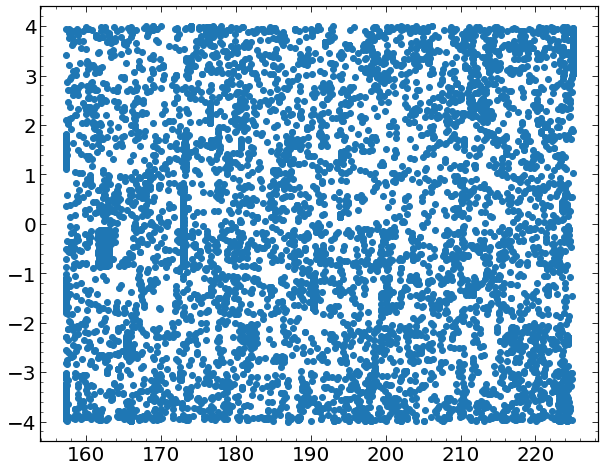

In [310]:
#plt.figure(figsize=(15,15))
plt.scatter(df_nan[(df_nan['cluster_label']=='ambiguous') & (df_nan['class']=='ambiguous') 
                   & (df_nan['Decmax']>-10)]['RAmax'],
           df_nan[(df_nan['cluster_label']=='ambiguous') & (df_nan['class']=='ambiguous') 
                  & (df_nan['Decmax']>-10)]['Decmax'])
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
plt.show()

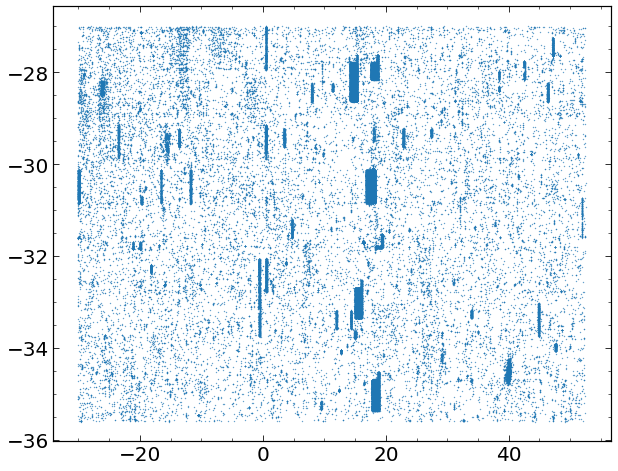

In [311]:
#plt.figure(figsize=(15,15))
plt.scatter(df_nan[(df_nan['missing_bands']==True) & (df_nan['Decmax']<-20)]['RAmax'],
           df_nan[(df_nan['missing_bands']==True) & (df_nan['Decmax']<-20)]['Decmax'],s=0.1)
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
plt.show()

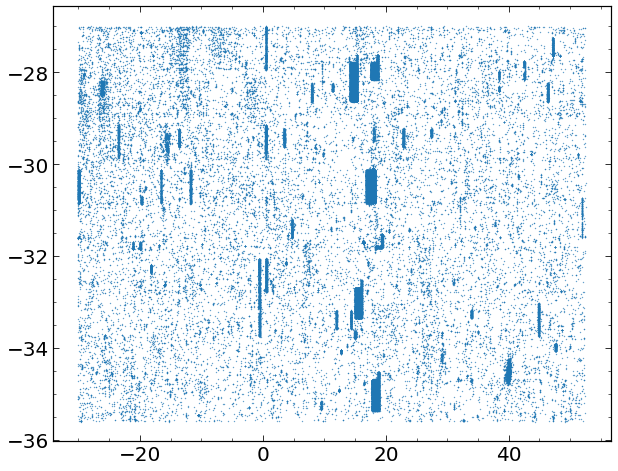

In [312]:
#plt.figure(figsize=(15,15))
plt.scatter(df_nan[(df_nan['missing_bands']==True) & (df_nan['Decmax']<-20)]['RAmax'],
           df_nan[(df_nan['missing_bands']==True) & (df_nan['Decmax']<-20)]['Decmax'],s=0.1)
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
plt.show()

In [313]:
smol=df_nan[(df_nan['Decmax']>-20) & (df_nan['missing_bands']==True)]
for frameID in np.unique(smol['FrameID']):
    print(frameID,len(smol[smol['FrameID']==frameID]))

KeyError: 'FrameID'

In [314]:
len(df_nan[df_nan['missing_bands']==True])/len(df_nan)

0.010671451329545216

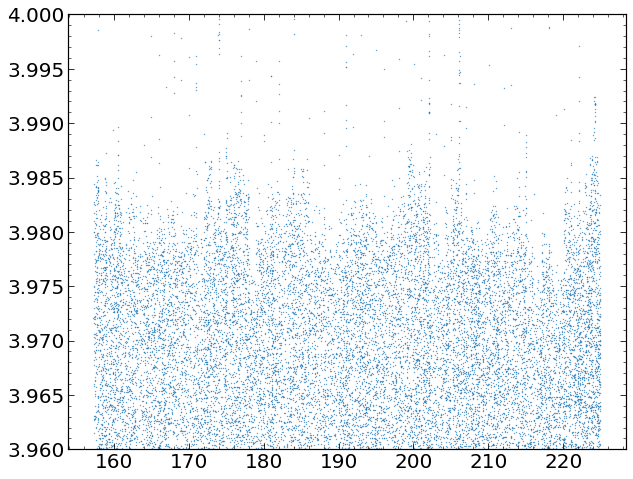

In [315]:
plt.scatter(df_nan[df_nan['Decmax']>-20]['RAmax'],df_nan[df_nan['Decmax']>-20]['Decmax'],s=0.1)
plt.ylim(3.96,4.0)
plt.show()

In [316]:
diffuse[np.log10(diffuse['R50'])>0.1]

RAmax    Decmax       R50       R90      R100     axrat  \
uberID                                                                          
175970578006337  174.601809 -2.555288  1.445349  2.571791  3.911789  0.829365   
175000444400633  174.213032 -0.030610  3.110036  5.678449  7.980892  0.683199   
175981131108650  174.640696 -1.362515  2.223377  3.937123  6.222353  0.785052   
175991114104484  174.654938 -0.709695  2.668175  4.533426  7.142297  0.821040   
174980274901705  174.354480 -1.941246  2.104279  3.701793  5.058558  0.888914   
...                     ...       ...       ...       ...       ...       ...   
220990529803868  220.141886 -0.761038  1.539305  2.701479  3.952144  0.929898   
220990498604442  220.167886 -0.713204  1.806562  3.350291  5.436580  0.683330   
220990429308730  220.225627 -0.355873  3.506947  6.216135  8.756154  0.598215   
220990382508978  220.264627 -0.335205  2.068585  3.552825  5.262295  0.507953   
220990254708134  220.371129 -0.405533  1.631141  2.873562  4.680833  0.686445   

                     class cluster_label  missing_bands  mag_u_tot  mag_g_tot  \
uberID                                                                          
175970578006337     galaxy        galaxy          False  22.558112  21.516891   
175000444400633  ambiguous        galaxy          False  20.891472  19.754205   
175981131108650     galaxy        galaxy          False  21.962240  20.862758   
175991114104484  ambiguous        galaxy          False  21.328805  20.396040   
174980274901705  ambiguous        galaxy          False  21.456556  20.446064   
...                    ...           ...            ...        ...        ...   
220990529803868     galaxy        galaxy          False  22.443392  21.120913   
220990498604442  ambiguous        galaxy          False  22.209978  21.280805   
220990429308730     galaxy        galaxy          False  21.045796  19.926214   
220990382508978     galaxy        galaxy          False  21.644611  21.548367   
220990254708134  ambiguous          star          False  23.175673  21.726915   

                 mag_r_tot  mag_i_tot  mag_z_tot  mag_y_tot  mag_j_tot  \
uberID                                                                   
175970578006337  21.086080  21.058136  20.916944  20.768413  21.201618   
175000444400633  19.469117  19.356752  19.373508  19.316349  19.057581   
175981131108650  20.504987  20.377831  20.058542  20.078926  21.132505   
175991114104484  19.999284  19.826741  19.904974  20.113091  19.651856   
174980274901705  20.058812  19.954552  20.517160  20.204767  19.739353   
...                    ...        ...        ...        ...        ...   
220990529803868  20.823116  20.631870  20.580110  20.287115  20.606936   
220990498604442  20.825887  20.804365  20.570071  20.239063  20.207295   
220990429308730  19.551521  19.290795  19.419515  19.292878  19.209787   
220990382508978  20.825778  21.112435  20.921598  20.974951  21.016551   
220990254708134  21.326950  21.231911  21.179606  21.050753  21.108552   

                 mag_h_tot  mag_k_tot   flux_Zt  log10seeing         SB  \
uberID                                                                    
175970578006337  21.308815  20.815127  0.000016    -0.190176  22.756545   
175000444400633  18.648962  19.293632  0.000065    -0.207660  22.666579   
175981131108650  20.156891  20.412149  0.000034    -0.194113  22.773729   
175991114104484  19.150272  19.946933  0.000040    -0.180795  23.064831   
174980274901705  19.531007  19.985373  0.000023    -0.194934  23.247701   
...                    ...        ...       ...          ...        ...   
220990529803868  20.273330  20.081892  0.000021    -0.210613  22.680696   
220990498604442  20.124159  20.516660  0.000021    -0.210613  22.683786   
220990429308730  19.223160        NaN  0.000062    -0.210613  22.829179   
220990382508978  20.709655  20.038815  0.000016    -0.210613  23.007398   
220990254708134  20.827101  21.476608  0.000012    

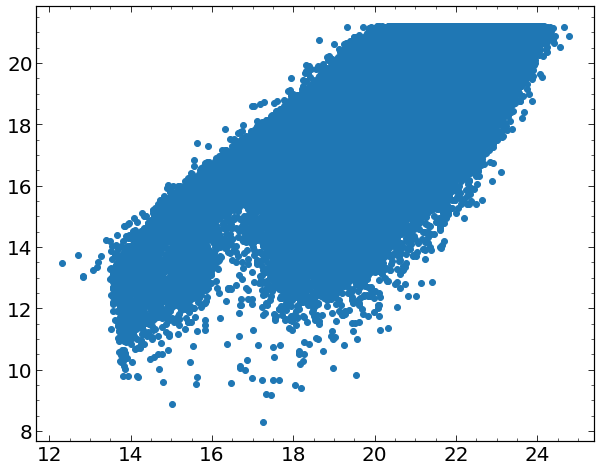

In [317]:
plt.scatter(df_nan['SB'],df_nan['mag_z_tot'])

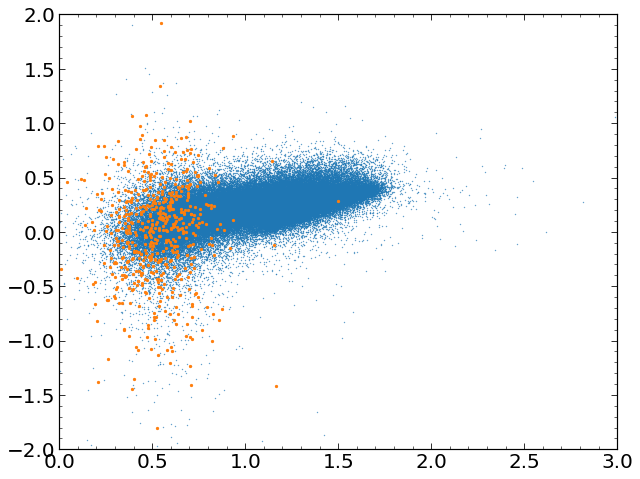

In [318]:
plt.scatter(sample['mag_g_tot']-sample['mag_i_tot'],sample['mag_j_tot']-sample['mag_k_tot'],s=0.1)
plt.scatter(diffuse['mag_g_tot']-diffuse['mag_i_tot'],diffuse['mag_j_tot']-diffuse['mag_k_tot'],s=5)
plt.xlim(0,3)
plt.ylim(-2,2)
plt.show()

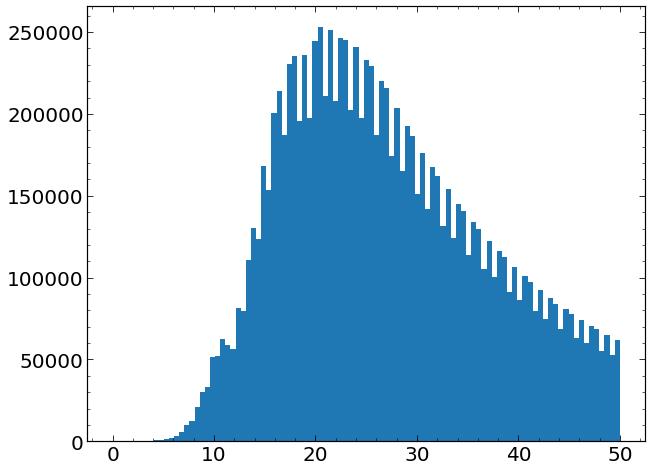

In [319]:
plt.hist(np.pi*df_nan['R100']**2 * df_nan['axrat'],bins=np.linspace(0,50,100))
plt.show()

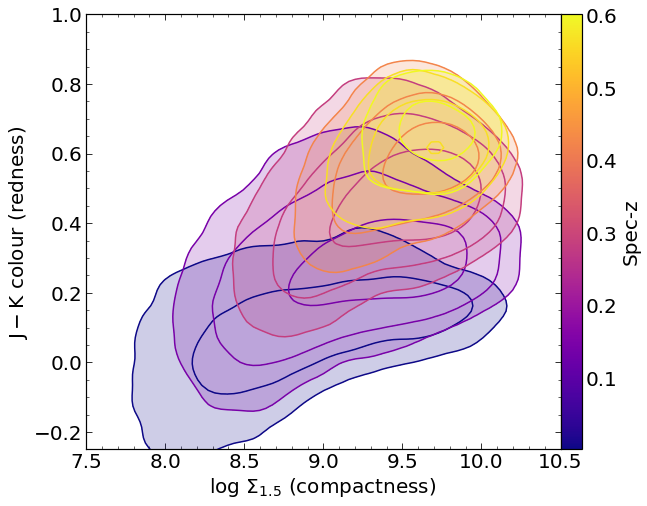

In [320]:
fig=plt.figure()
ax = fig.add_subplot(1,1,1)
z_bins=[[0,0.1],[0.1,0.2],[0.2,0.3],[0.3,0.4],[0.4,0.5],[0.5,0.6]]
cmap = matplotlib.cm.get_cmap('plasma')
for i in range(len(z_bins)):
    rgba=cmap(i*60)
    sample=waves_matches[(waves_matches['Z']>z_bins[i][0]) & (waves_matches['Z']<z_bins[i][1]) & 
                         (waves_matches['spec_class']=='galaxy')]
    z,x,y=np.histogram2d(sample['sig'],
                     sample['mag_j_tot'] - 
                     sample['mag_k_tot'],
                     bins=(np.linspace(7,11,100),np.linspace(-0.3,1.2,100)))
    xcenters = (x[:-1] + x[1:]) / 2
    ycenters = (y[:-1] + y[1:]) / 2
    plt.contour(xcenters, ycenters, gaussian_filter(z.transpose(), 2), 
           levels=np.logspace(0.5,3,5),zorder=3,colors=[rgba])
    plt.contourf(xcenters, ycenters, gaussian_filter(z.transpose(), 2),
               levels=np.logspace(0.5,3,5),zorder=2,colors=[(rgba[0],rgba[1],rgba[2],rgba[3]/5)])
    del sample
plt.xlim(7.5,10.5)
plt.ylim(-0.25,1)
plt.xlabel(r'$\mathrm{log} \ \Sigma_{1.5} \  \mathrm{(compactness)}$ ')
plt.ylabel(r'$\mathrm{J-K \ colour \ (redness)}$ ')
sc=ax.scatter(waves_matches[(waves_matches['Z']<0.601) & (waves_matches['spec_class']=='galaxy')]['sig'],
           waves_matches[(waves_matches['Z']<0.601) & (waves_matches['spec_class']=='galaxy')]['mag_j_tot'],
           c=waves_matches[(waves_matches['Z']<0.601) & (waves_matches['spec_class']=='galaxy')]['Z'],cmap='plasma')
cbar = fig.colorbar(sc, pad=0,label='Spec-z')
cbar.ax.minorticks_off()
cbar.ax.tick_params(size=0)
plt.show()

In [321]:
df_compact=pd.read_csv('../compact-sample.csv')

In [322]:
df_compact

objid         ra       dec   log_mass_star  \
0    1237661972264124583  196.11667   7.92798        10.03255   
1    1237665550497087564  207.24358  26.61080        10.09888   
2    1237663783144521731   47.61596  -0.83079        10.10804   
3    1237657071158362183   25.61220   0.21338        10.12814   
4    1237661070319419515  143.92354  11.97274        10.12959   
..                   ...        ...       ...             ...   
159  1237651736316870684  232.60652   1.56096        11.16578   
160  1237651801235652715  153.52456   0.10567        11.19539   
161  1237665427555745936  202.15340  27.95778        11.34101   
162  1237658300610379866  164.47536   8.00720        11.38024   
163  1237667912211562501  204.32803  24.38427        11.47697   

      log_sigma_1pt5   quenched_flag        z    z_err   r_50_kpc  
0           10.68218               1  0.04973  0.00001    0.36890  
1           10.50308               1  0.07062  0.01250    0.53769  
2           10.62756               0  0.08018  0.00002    0.45046  
3           10.51380               1  0.07888  0.02773    0.55321  
4           10.54969               1  0.09305  0.02216    0.52473  
..               ...             ...      ...      ...        ...  
159         10.69593               1  0.14693  0.02133    2.05700  
160         10.77092               0  0.14107  0.00003    1.91860  
161         10.56512               1  0.13417  0.00004    3.29046  
162         10.50777               1  0.09653  0.01222    3.81635  
163         10.75958               0  0.10764  0.00011    3.00791  

[164 rows x 9 columns]

In [323]:
max_sep=1*u.arcsec
waves = SkyCoord(ra=df_nan['RAmax'].values*u.degree, dec=df_nan['Decmax'].values*u.degree)
compact = SkyCoord(ra=df_compact[' ra'].values*u.degree, dec=df_compact[' dec'].values*u.degree)
idx, d2d, d3d = waves.match_to_catalog_sky(compact)
sep_constraint = d2d < max_sep
compact_matches=df_nan.iloc[sep_constraint]
compact_waves_matches=df_compact.iloc[idx[sep_constraint]]

In [324]:
len(compact_matches)

16

(array([13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

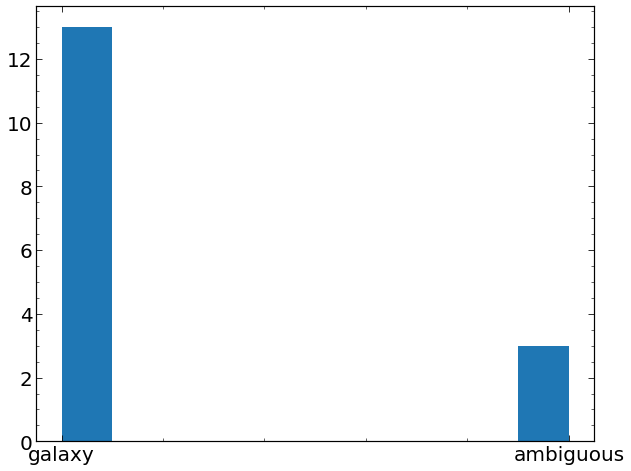

In [325]:
plt.hist(compact_matches['class'])

(array([ 0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

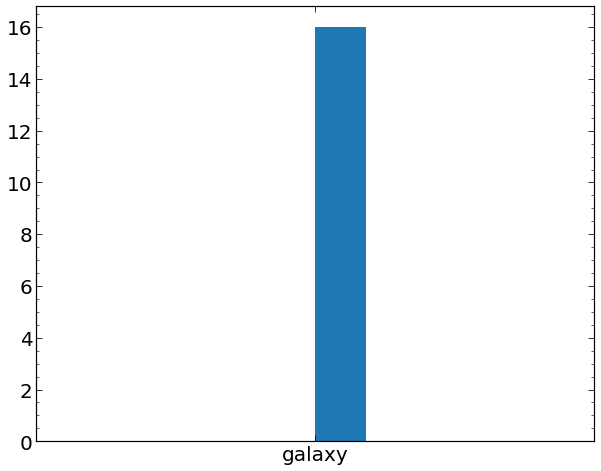

In [326]:
plt.hist(compact_matches['cluster_label'])

In [327]:
gama_compact=pd.read_csv('../gama_compact.csv')

In [328]:
gama_compact.columns

Index(['CATAID', 'RA', 'Dec', 'Zspec', 'log 10 Mstellar', 'Unnamed: 5',
       'log10<', 'log 10(Pe)'],
      dtype='object')

In [329]:
max_sep=0.6*u.arcsec
waves = SkyCoord(ra=df_nan['RAmax'].values*u.degree, dec=df_nan['Decmax'].values*u.degree)
gamacompact = SkyCoord(ra=gama_compact['RA'].values*u.degree, dec=gama_compact['Dec'].values*u.degree)
idx, d2d, d3d = waves.match_to_catalog_sky(gamacompact)
sep_constraint = d2d < max_sep
gama_compact_matches=df_nan.iloc[sep_constraint]
gama_compact_waves_matches=gama_compact.iloc[idx[sep_constraint]]

(array([14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

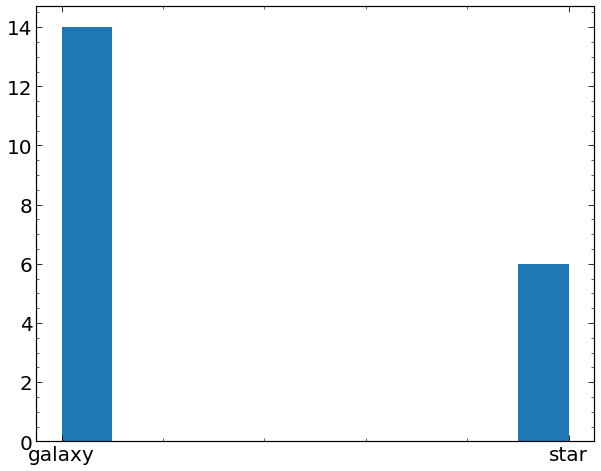

In [330]:
plt.hist(gama_compact_matches['cluster_label'])

(array([12.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  1.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

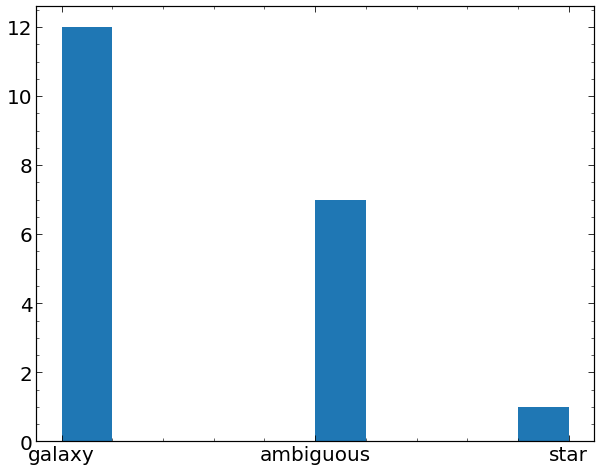

In [331]:
plt.hist(gama_compact_matches['class'])

In [332]:
import matplotlib.font_manager

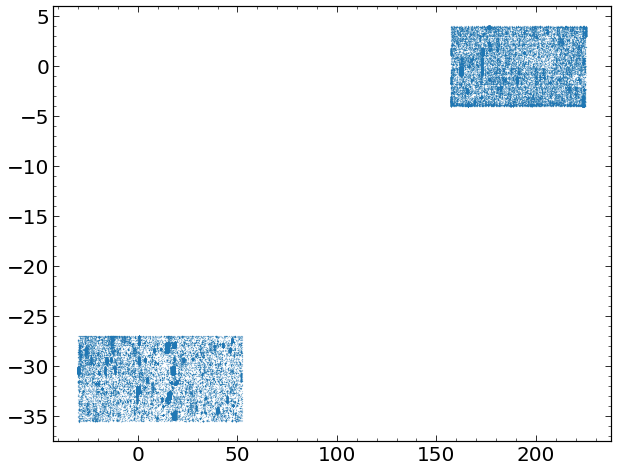

In [333]:
plt.scatter(df_nan[df_nan['missing_bands']==True]['RAmax'],
            df_nan[df_nan['missing_bands']==True]['Decmax'],
           s=0.01)
plt.show()

In [334]:
df_nan[df_nan['missing_bands']==True]['RAmax']

uberID
158980012903209    158.572885
158981065401518    157.695377
158980900307446    157.833071
158980296711568    158.336178
158980045206828    158.545882
                      ...    
53651167705680      51.823038
53650771405841      52.227240
53651227306813      51.762878
53650524003233      52.480010
53650884801231      52.110706
Name: RAmax, Length: 159663, dtype: float64